# Stochastic Simulations Assignment 3: Reverse Engineering Predator-Prey System

#### Job Marcelis, 14000946

#### Ernani Hazbolatow, 14272210

#### Haitham Muhidin, 13970356

Below are the required `Python` packages to run the code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import dual_annealing
import pandas as pd

from joblib import Parallel, delayed

plt.rcParams['figure.dpi'] = 300

To get a better understanding of the Lotka Volterra equations, we solve them using the following parameters: $\alpha = 3$, $\beta = 2$, $\delta = -1$, $\gamma = -2$. Furthermore, we use `solve_ivp` to solve the system of equations deterministically.

In [2]:
def LV_eqs(t, var, params):
    """Calculates next iteration of the Lotka-Volterra equations

    Args:
        t (float): time (not used but required for solve_ivp)
        var (list): predator and prey populations
        params (list): list of model parameters: alpha, beta, gamma, and delta

    Returns:
        list: next iteration of the model
    """
    x, y = var
    a, b, c, d = params

    dxdt = a*x - b*x*y
    dydt = - c*y + d*x*y

    return [dxdt, dydt]

def solve_LV(start_time, stop_time, time_span, initial_conditions, params):
    """Solves the Lotka_Volterra system for some initial conditions, time span, and parameters.

    Args:
        start_time (int): start time
        stop_time (int): stop time
        time_span (array): array of time steps
        initial_conditions (list): list of initial predator and prey populations
        params (list): list of parameters for the model

    Returns:
        arrays: time evolution of the predator and prey populations and the time.
    """
    result = solve_ivp(LV_eqs, [start_time, stop_time], initial_conditions, args=(params,), t_eval=time_span, method='RK45')
    X = result.y[0, :]
    Y = result.y[1, :]
    t = result.t

    return X, Y, t

Below, we solve the LV equations for some initial conditions and parameters from 0 to 20 time units. This way we can visualize the dynamics of the system.

In [3]:
init_cond = [4, 2]
params = [3, 2, 1, 2]
time_arr = np.linspace(0, 20, 1000)
X, Y, t = solve_LV(0, 20, time_arr, init_cond, params)

In addition to showing the time evolution of the deterministic model, we can also plot the phase space for multiple initial conditions. This reveals the periodic behaviour.

In [4]:
pred_pop = [1, 3, 5, 7]
phase_plot_X = np.zeros((len(pred_pop), 1000))
phase_plot_Y = np.zeros((len(pred_pop), 1000))

for i, pop in enumerate(pred_pop):
    X_phase, Y_phase, _ = solve_LV(10, 20, np.linspace(10, 20, 1000), [4, pop], params)
    phase_plot_X[i, :] = X_phase
    phase_plot_Y[i, :] = Y_phase

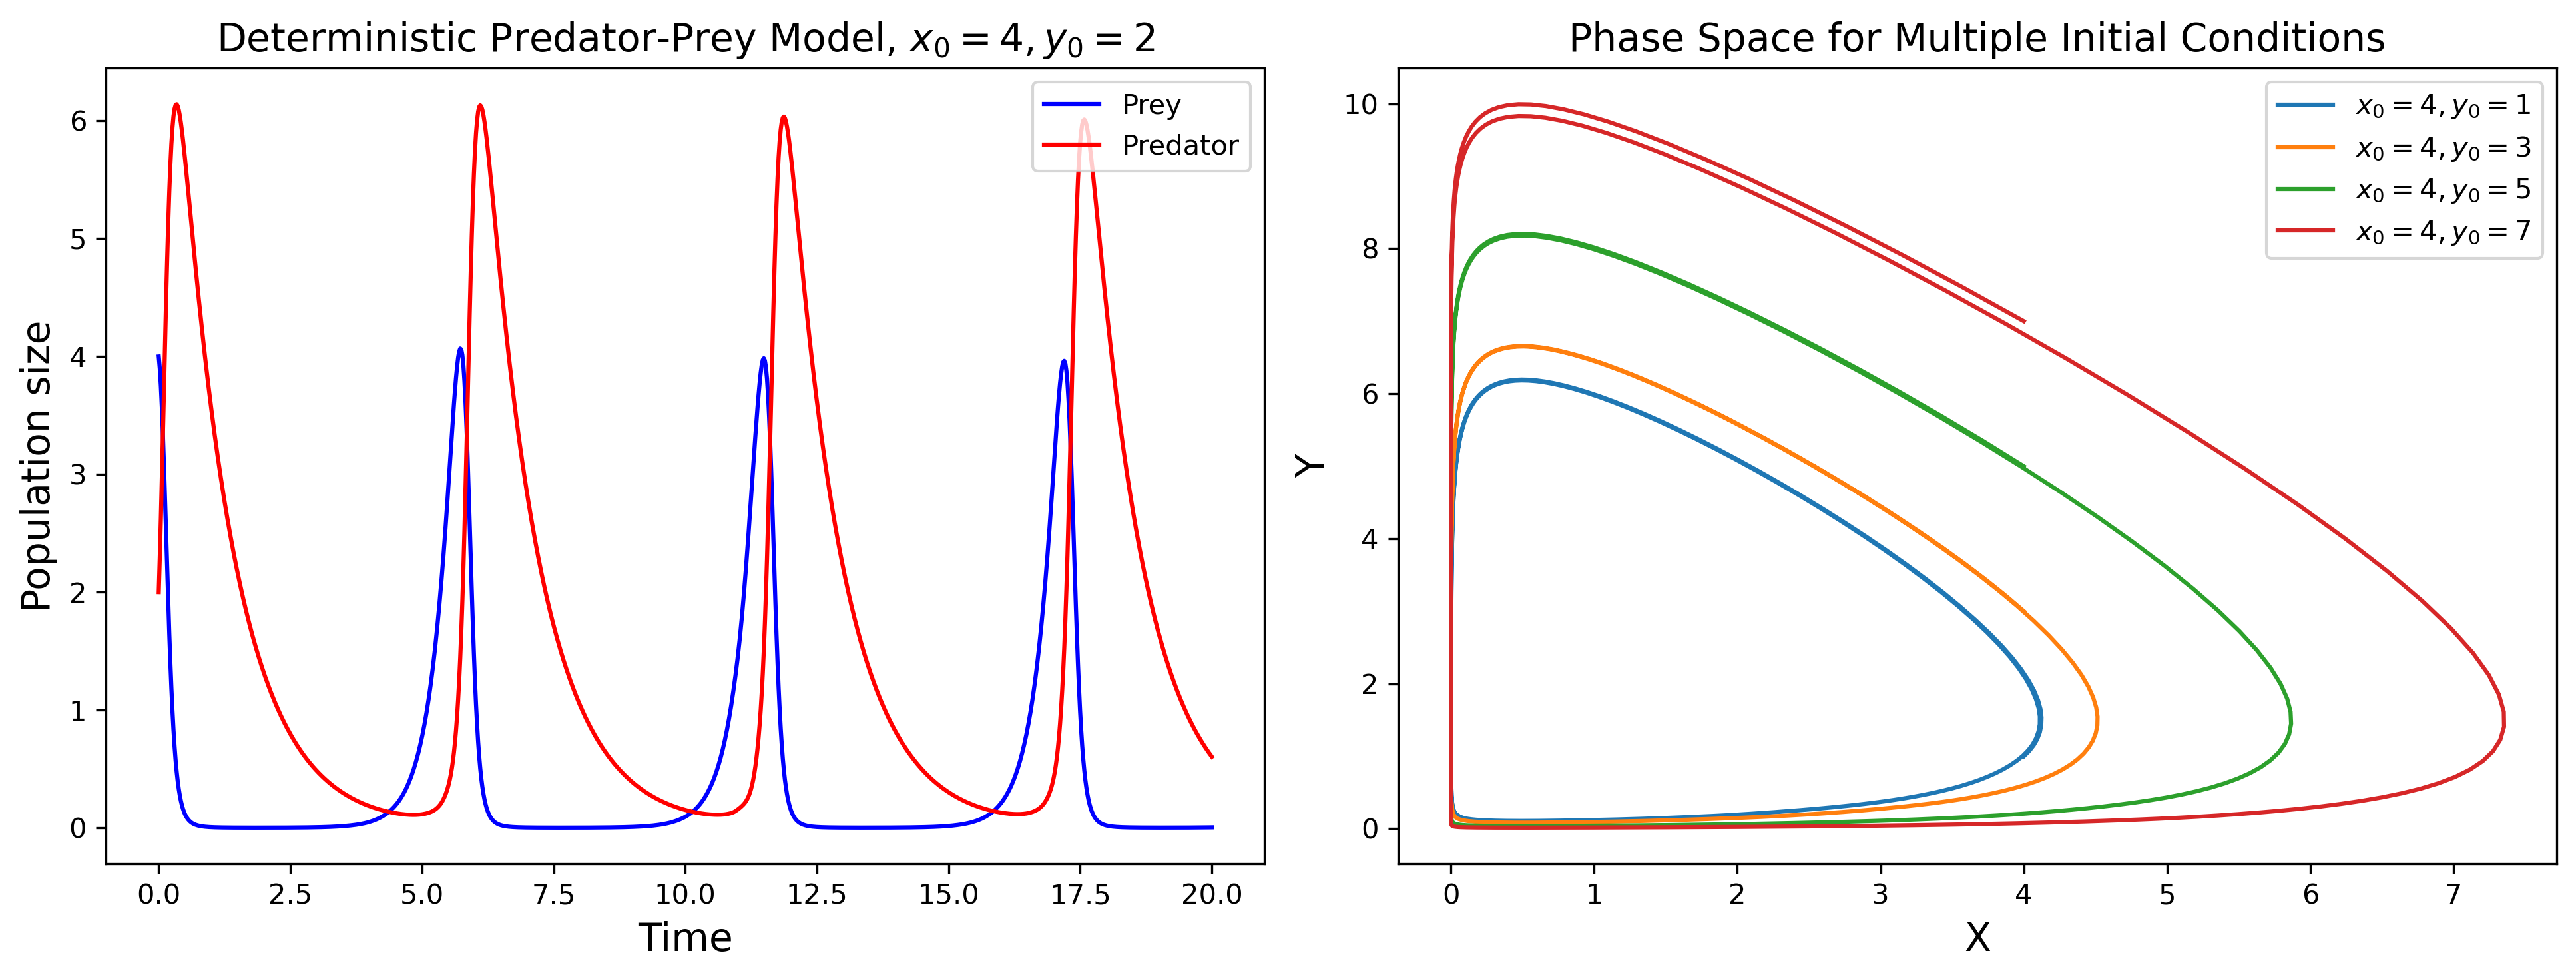

In [5]:
colors = ['#87CEEB', '#ADD8E6', '#00BFFF', '#1E90FF']
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.title(fr'Deterministic Predator-Prey Model, $x_0 = {{{init_cond[0]}}}, y_0 = {{{init_cond[1]}}}$', fontsize=14)
plt.plot(t, X, color='blue', label='Prey')
plt.plot(t, Y, color='red', label='Predator')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title('Phase Space for Multiple Initial Conditions', fontsize=14)
for i in range(len(pred_pop)):
    plt.plot(phase_plot_X[i, :], phase_plot_Y[i, :], label=fr'$x_0 = {{{init_cond[0]}}}, y_0 = {{{pred_pop[i]}}}$')
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

Now, we plot the data that was given in `predator-prey-data.csv`.

In [6]:
data = pd.read_csv('predator-prey-data.csv')
t_data = data['t']
X_data = data['x']
Y_data = data['y']
X_data_var = np.var(X_data)
Y_data_var = np.var(Y_data)

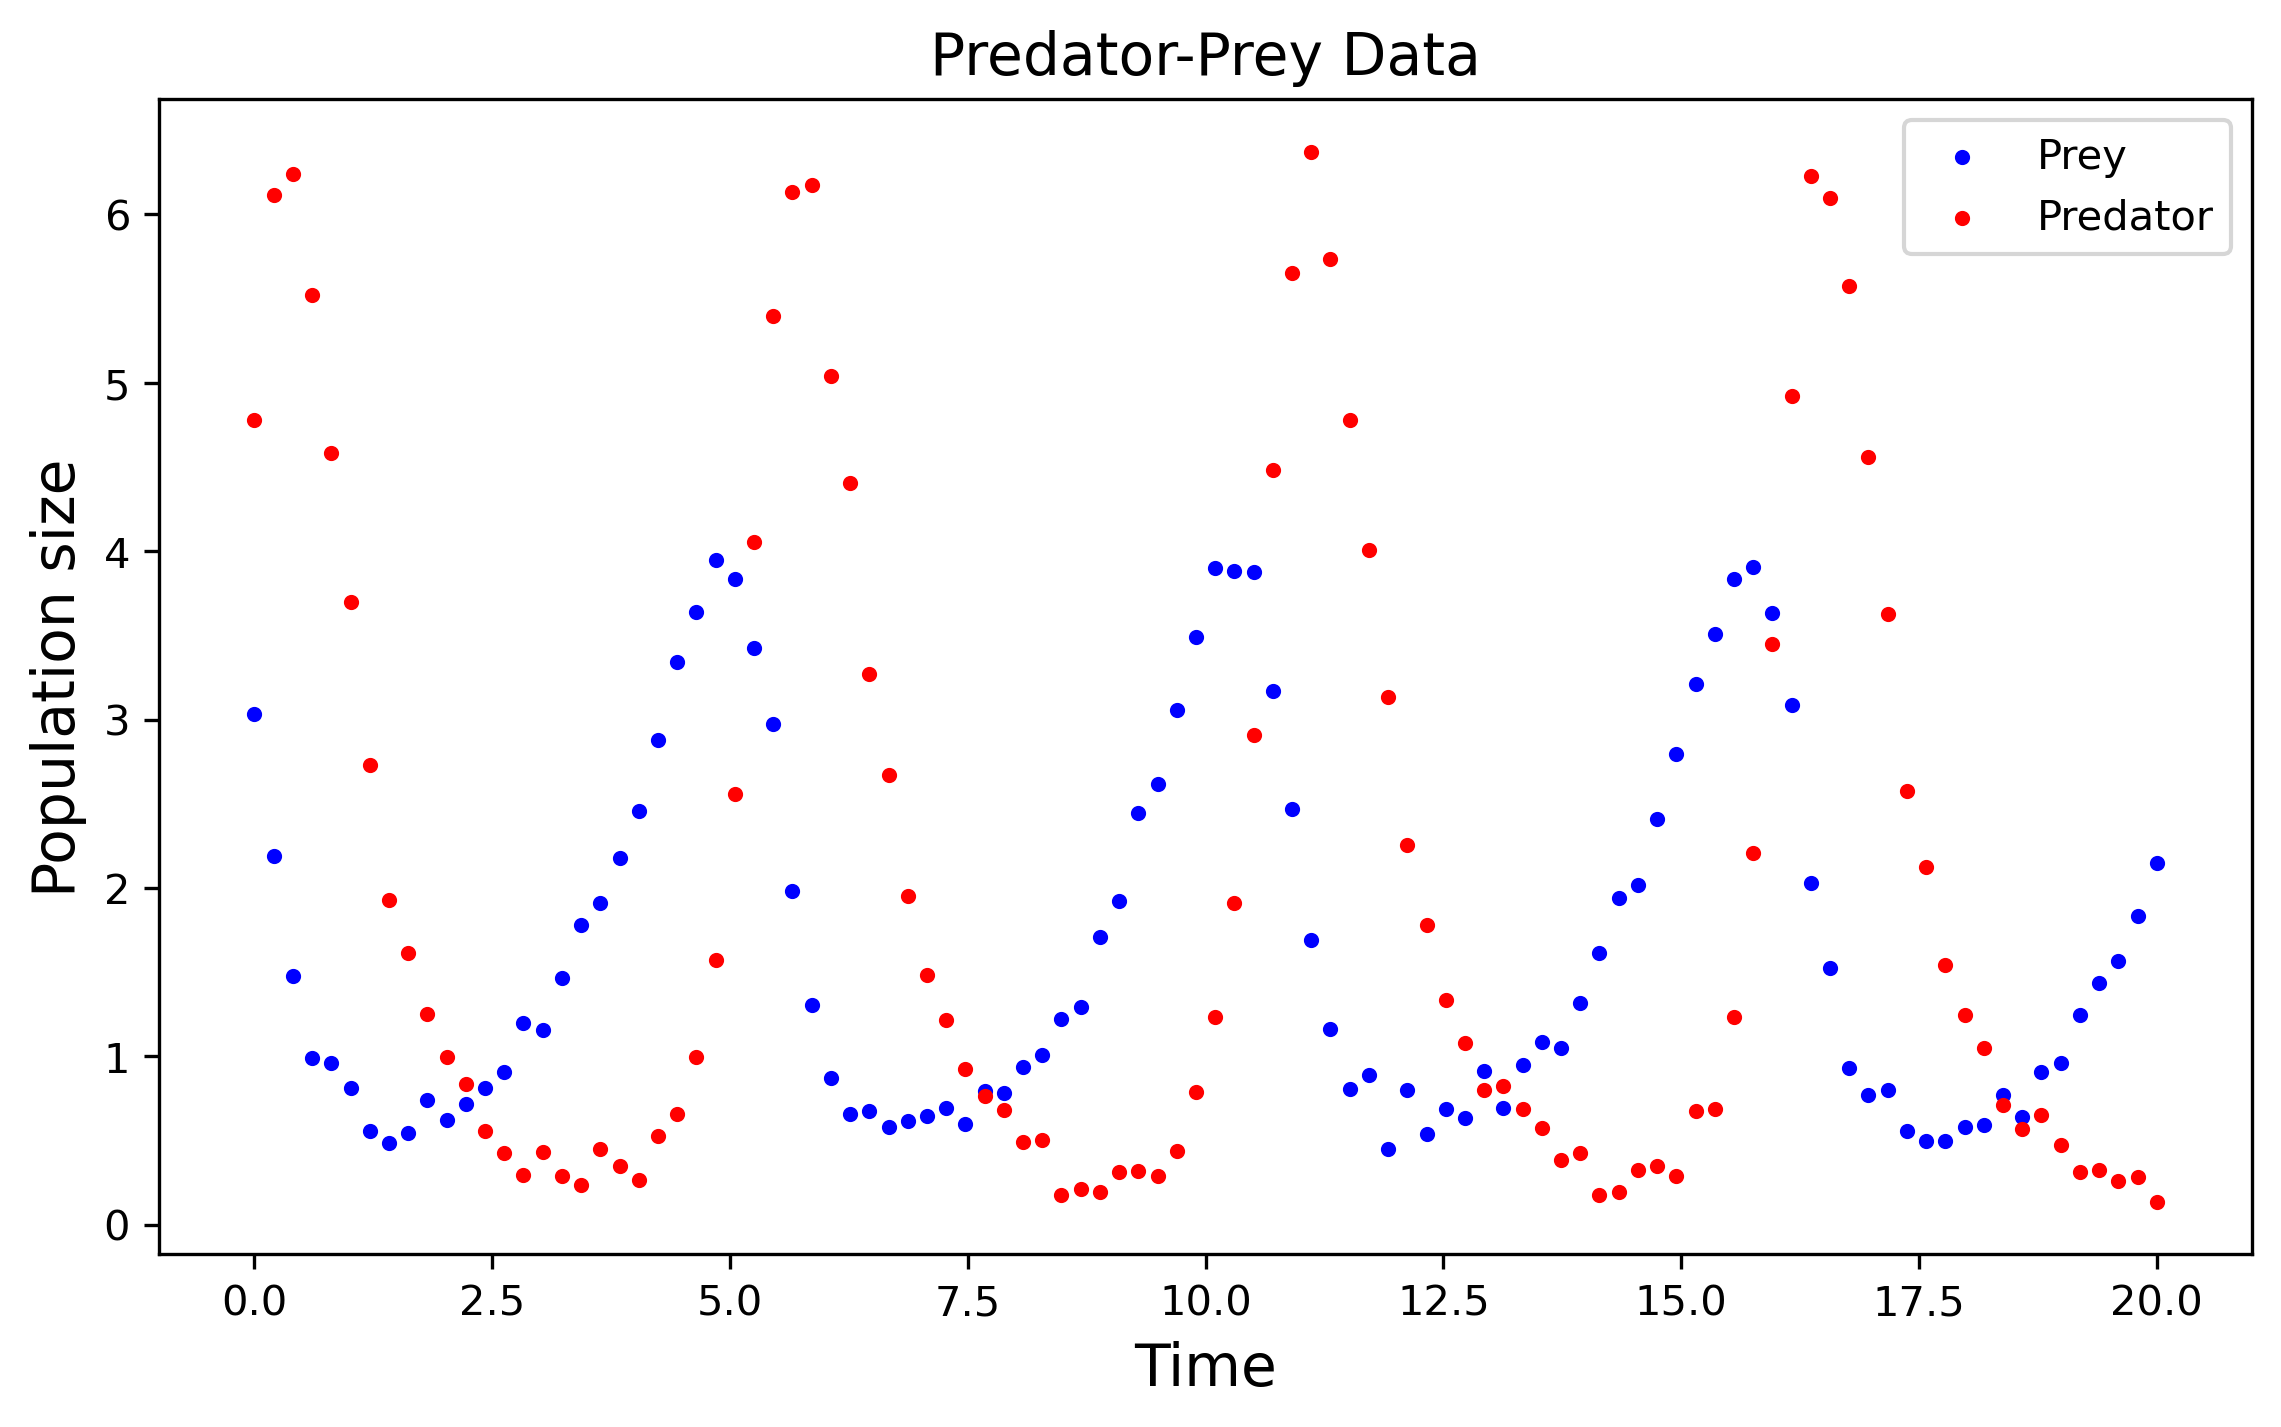

In [7]:
plt.figure(figsize=(9, 5))
plt.title('Predator-Prey Data', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend()
plt.show()

#### Optimization of the model parameters

The goal is to find the best parameters to describe the data, which is done with two different optimizing algorithms, Hill climbing and Simulated Annealing. First, we define two objective functions, the mean squared error (MSE) and the mean absolute error (MAE). Using these functions, we can calculate the difference between the siimulated results and the experimental results.

In [8]:
def MAE(data, model):
    return np.mean(np.abs(data - model))

def MSE(data, model):
    return np.mean((data - model)**2)

In [ ]:
def hill_climbing_sep(init_guess, increment, iterations, obj_func, seed=1):

    a, b, c, d = init_guess
    lowest_error = 1e5
    err_list = []
    x_errs = []  # will be iterations + 1 long due to also having to compute the initial guess
    y_errs = []  # same as x_errs
    np.random.seed(seed)
    abcd_incr_list = np.random.uniform(-increment, increment, (4, iterations))

    model_X, model_Y, model_t = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], [a, b, c, d])
    x_err = obj_func(X_data, model_X)
    y_err = obj_func(Y_data, model_Y)
    x_errs.append(x_err)
    y_errs.append(y_err)

    abcd_list = [a,b,c,d]

    for i in range(iterations):
        for j in range(len(abcd_list)):
            abcd_list[j] += abcd_incr_list[j, i]

        model_X, model_Y, model_t = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], abcd_list)
        x_err = obj_func(X_data, model_X)
        y_err = obj_func(Y_data, model_Y)
        x_errs.append(x_err)
        y_errs.append(y_err)

        if x_errs[-1] > x_errs[-2]:
            abcd_list[0] -= abcd_incr_list[0, i]
            abcd_list[1] -= abcd_incr_list[1, i]
        if y_errs[-1] > y_errs[-2]:
            abcd_list[2] -= abcd_incr_list[2, i]
            abcd_list[3] -= abcd_incr_list[3, i]

    return [abcd_list, x_errs, y_errs]

In [9]:
def hill_climbing(init_guess, increment, iterations, obj_func, seed=1):

    a, b, c, d = init_guess
    lowest_error = 1e5
    err_list = []
    x_errs = []  # will be iterations + 1 long due to also having to compute the initial guess
    y_errs = []  # same as x_errs
    np.random.seed(seed)
    abcd_incr_list = np.random.uniform(-increment, increment, (4, iterations))

    model_X, model_Y, model_t = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], [a, b, c, d])
    x_err = obj_func(X_data, model_X)
    y_err = obj_func(Y_data, model_Y)
    x_errs.append(x_err)
    y_errs.append(y_err)
    error_sum_old =  x_err + y_err
    abcd_list = [a,b,c,d]
    for i in range(iterations):
        for j in range(len(abcd_list)):
            abcd_list[j] += abcd_incr_list[j, i]
            model_X, model_Y, model_t = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], abcd_list)
            error_sum_new = 1*  obj_func(X_data, model_X) + 1 * obj_func(Y_data, model_Y)
            if error_sum_new < error_sum_old:
                error_sum_old = error_sum_new
            else:
                abcd_list[j] -= abcd_incr_list[j, i]
        # model_X, model_Y, model_t = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], [a, b, c, d])

        x_err = obj_func(X_data, model_X)
        y_err = obj_func(Y_data, model_Y)
        x_errs.append(x_err)
        y_errs.append(y_err)
    return [abcd_list, x_errs, y_errs]

In [10]:
def calc_mean_conf_hill(results):
    means = np.mean(results, axis=0)
    conf = 1.96 * np.std(results, axis=0) / np.sqrt(len(results))
    return means, conf

In [11]:
def calc_mean_conf(results):
    means = np.mean(results, axis=0)
    conf = 1.96 * np.std(results, axis=0) / np.sqrt(len(results))
    return means, conf

To determine how good the fit is, we calculate the reduced $\chi^2$. Since the data points do not have errors, we estimate the error with the standard deviation from the residuals. Furthermore, since we have to curves to fit, the total $\chi^2$ is the sum of both fitted curves. The degrees of freedom is $\nu = N - p = 200 - 4$.

In [12]:
def reduced_chi2(model_prey, model_predator):
    std_prey = np.std(X_data - model_prey)
    std_predator = np.std(Y_data - model_predator)
    chi2 = sum((X_data - model_prey)**2 / std_prey**2) + sum((Y_data - model_predator)**2 / std_predator**2)
    red_chi2 = chi2 / (2*len(X_data) - 4)
    return red_chi2

In [33]:
def simulation_wrapper_sep(init_guess, increment, iterations, obj_func, seed):
    return hill_climbing(init_guess, increment, iterations, obj_func, seed=seed)

def simulate_parallel_sep(n_runs, init_guess, increment, iterations, obj_func):
    results = Parallel(n_jobs=2)(delayed(simulation_wrapper_sep)(init_guess, increment, iterations, obj_func, seed=s) for s in range(n_runs))
    abcds = np.array([results[j][0] for j in range(n_runs)])

    errors_x = np.array([results[k][1] for k in range(n_runs)])
    errors_y = np.array([results[g][2] for g in range(n_runs)])
    return [abcds, errors_x, errors_y]

In [35]:
hill_clim_fit_MAE_sep = simulate_parallel_sep(50, [1, 1, 2, 1], 0.01, 1000, MAE)
hill_clim_fit_MSE_sep = simulate_parallel_sep(50, [1, 1, 2, 1], 0.01, 1000, MSE)

In [36]:
means_MAE_sep, conf_MAE_sep = calc_mean_conf_hill(hill_clim_fit_MAE_sep[0])
for i in range(4):
    print(f'(MAE) Param: {means_MAE_sep[i]} +- {conf_MAE_sep[i]}')
means_MSE_sep, conf_MSE_sep = calc_mean_conf_hill(hill_clim_fit_MSE_sep[0])
for i in range(4):
    print(f'(MSE) Param: {means_MSE_sep[i]} +- {conf_MSE_sep[i]}')

(MAE) Param: 1.0387080641516986 +- 0.007695401006390349
(MAE) Param: 0.8285397777638043 +- 0.05016964186995589
(MAE) Param: 1.9544242136794563 +- 0.029218092317998517
(MAE) Param: 1.0339285979209556 +- 0.019153939778002643
(MSE) Param: 1.0441508891363327 +- 0.005705541086444049
(MSE) Param: 0.7663367195464801 +- 0.054170582600274
(MSE) Param: 1.9142524648183457 +- 0.031780635863244776
(MSE) Param: 1.0947306897471054 +- 0.029645622422425653


In [37]:
X_MAE_fit_sep, Y_MAE_fit_sep, t_MAE_fit_sep = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], means_MAE_sep)
X_MSE_fit_sep, Y_MSE_fit_sep, t_MSE_fit_sep = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], means_MSE_sep)

In [40]:
chi2_MSE_X_hill_sep, chi2_MSE_Y_hill_sep, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], means_MSE_sep)
chi2_MAE_X_hill_sep, chi2_MAE_Y_hill_sep, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], means_MAE_sep)
chi2_MSE_hill_sep = reduced_chi2(chi2_MSE_X_hill_sep, chi2_MSE_Y_hill_sep)
chi2_MAE_hill_sep = reduced_chi2(chi2_MAE_X_hill_sep, chi2_MAE_Y_hill_sep)
print(f'Reduced chi2 for Hill climbing using MSE: {chi2_MSE_hill_sep}')
print(f'Reduced chi2 for Hill climbing using MAE: {chi2_MAE_hill_sep}')

Reduced chi2 for Hill climbing using MSE: 2.059605879862664
Reduced chi2 for Hill climbing using MAE: 2.012817423539144


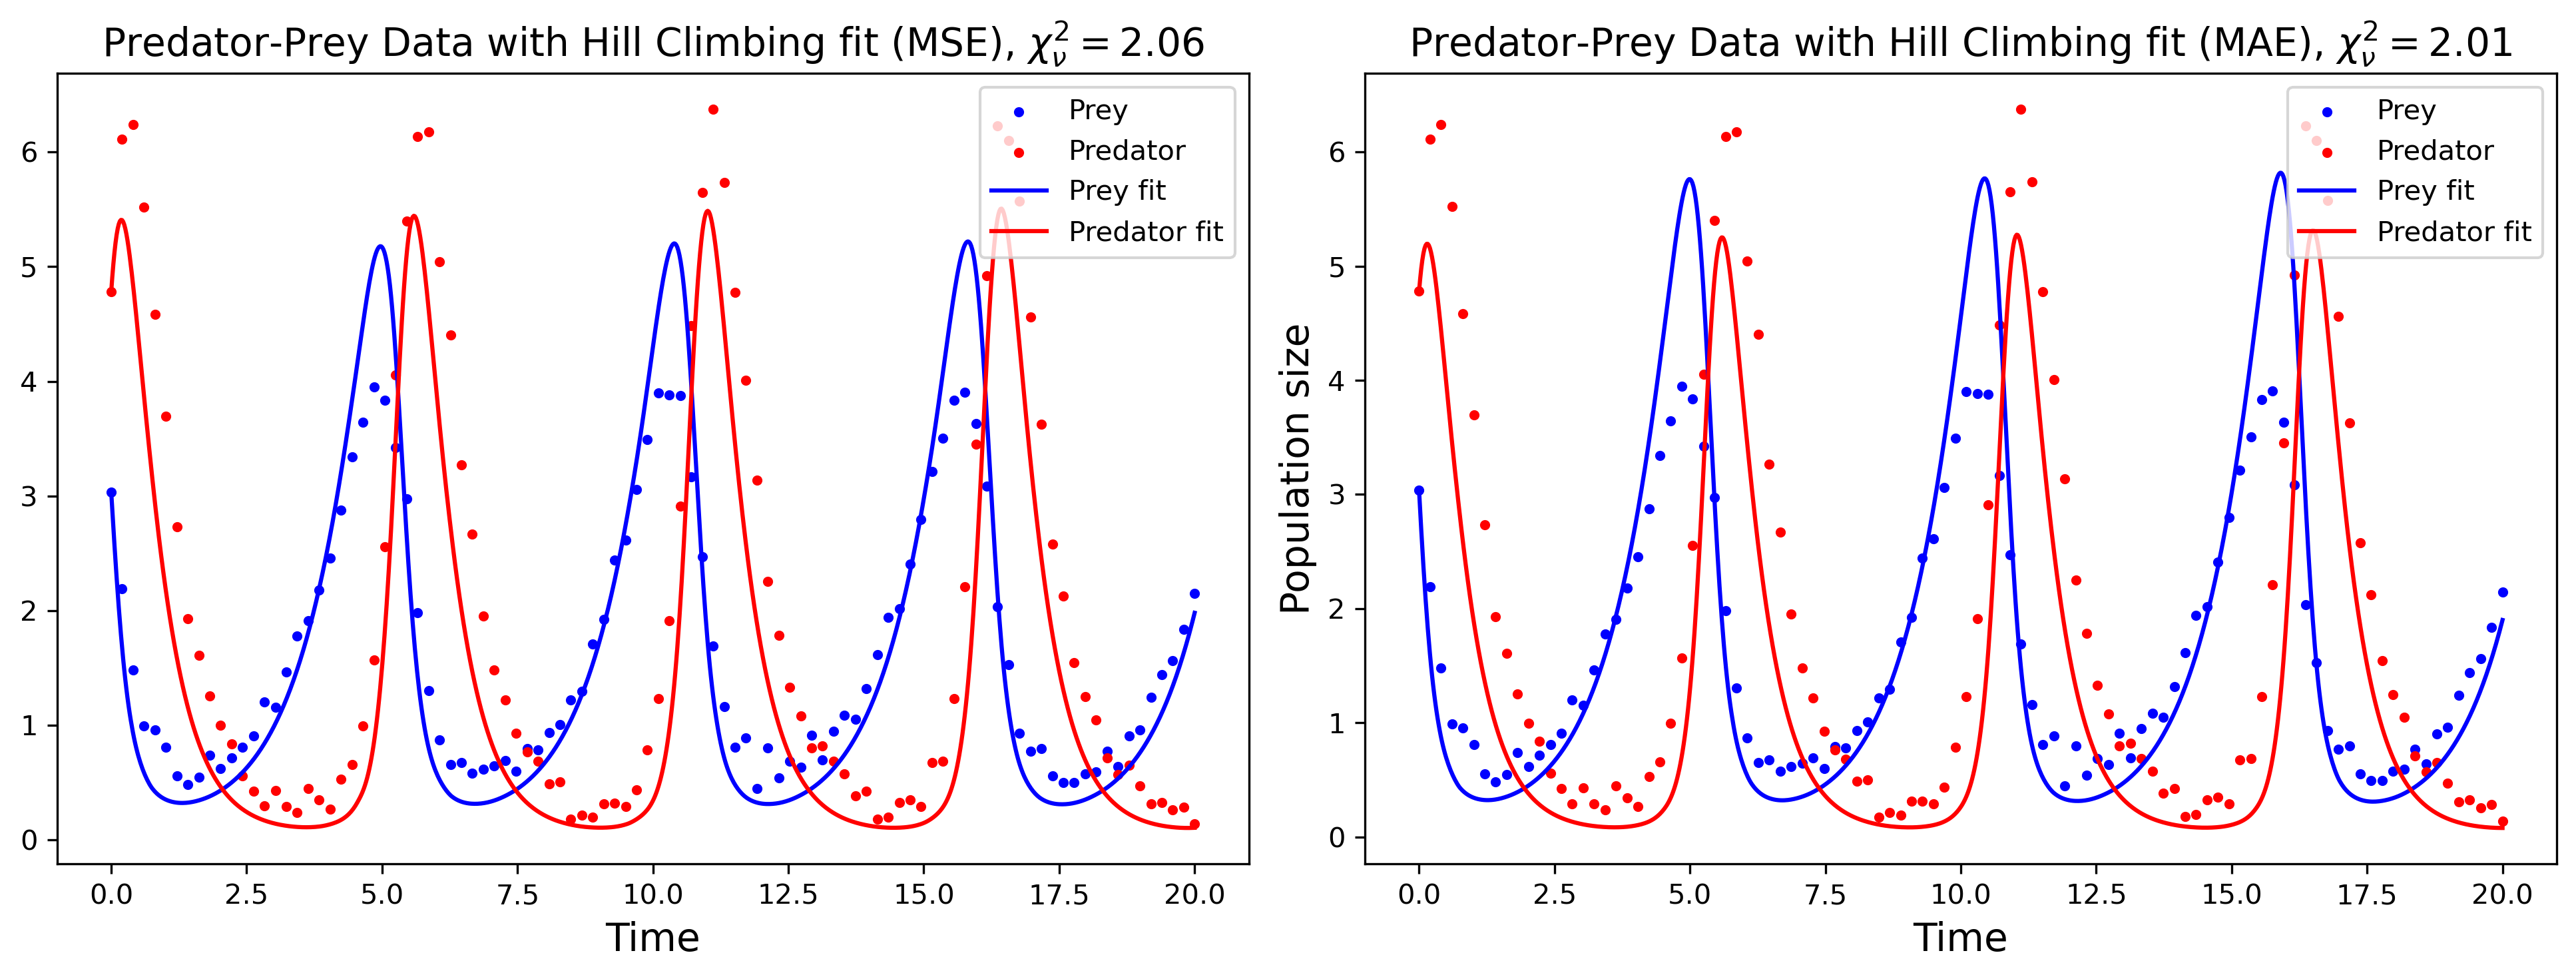

In [41]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.title(fr'Predator-Prey Data with Hill Climbing fit (MSE), $\chi^2_{{\nu}} = {{{round(chi2_MSE_hill_sep, 2)}}}$', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.plot(t_MSE_fit_sep, X_MSE_fit_sep, color='blue', label='Prey fit')
plt.plot(t_MSE_fit_sep, Y_MSE_fit_sep, color='red', label='Predator fit')
plt.xlabel('Time', fontsize=14)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title(fr'Predator-Prey Data with Hill Climbing fit (MAE), $\chi^2_{{\nu}} = {{{round(chi2_MAE_hill_sep, 2)}}}$', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.plot(t_MAE_fit_sep, X_MAE_fit_sep, color='blue', label='Prey fit')
plt.plot(t_MAE_fit_sep, Y_MAE_fit_sep, color='red', label='Predator fit')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [13]:
def simulation_wrapper(init_guess, increment, iterations, obj_func, seed):
    return hill_climbing(init_guess, increment, iterations, obj_func, seed=seed)

def simulate_parallel(n_runs, init_guess, increment, iterations, obj_func):
    results = Parallel(n_jobs=2)(delayed(simulation_wrapper)(init_guess, increment, iterations, obj_func, seed=s) for s in range(n_runs))
    abcds = np.array([results[j][0] for j in range(n_runs)])

    errors_x = np.array([results[k][1] for k in range(n_runs)])
    errors_y = np.array([results[g][2] for g in range(n_runs)])
    return [abcds, errors_x, errors_y]

In [14]:
hill_clim_fit_MSE = simulate_parallel(50, [1, 1, 2, 1], 0.01, 1000, MSE)

In [15]:
hill_clim_fit_MAE = simulate_parallel(50, [1, 1, 2, 1], 0.01, 1000, MAE)
# hill_clim_fit_MSE = simulate_parallel(50, [1, 1, 2, 1], 0.01, 1000, MSE)

In [16]:
minimum_xerr = np.min(hill_clim_fit_MAE[1][:,-1])
for i in range (len(hill_clim_fit_MAE[1][:,-1])):
    if hill_clim_fit_MAE[1][i,-1]== minimum_xerr:
        print(i)
        min_idx = i

42


In [17]:
minimum_yerr = np.min(hill_clim_fit_MAE[2][:,-1])
for i in range (len(hill_clim_fit_MAE[2][:,-1])):
    if hill_clim_fit_MAE[2][i,-1]== minimum_yerr:
        print(i)

8


In [18]:
means_MAE, conf_MAE = calc_mean_conf_hill(hill_clim_fit_MAE[0])
for i in range(4):
    print(f'(MAE) Param: {means_MAE[i]} +- {conf_MAE[i]}')
means_MSE, conf_MSE = calc_mean_conf_hill(hill_clim_fit_MSE[0])
for i in range(4):
    print(f'(MSE) Param: {means_MSE[i]} +- {conf_MSE[i]}')

(MAE) Param: 1.0387080641516986 +- 0.007695401006390349
(MAE) Param: 0.8285397777638043 +- 0.05016964186995589
(MAE) Param: 1.9544242136794563 +- 0.029218092317998517
(MAE) Param: 1.0339285979209556 +- 0.019153939778002643
(MSE) Param: 1.0441508891363327 +- 0.005705541086444049
(MSE) Param: 0.7663367195464801 +- 0.054170582600274
(MSE) Param: 1.9142524648183457 +- 0.031780635863244776
(MSE) Param: 1.0947306897471054 +- 0.029645622422425653


In [19]:
X_MAE_fit, Y_MAE_fit, t_MAE_fit = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], hill_clim_fit_MAE[0][2])
X_MSE_fit, Y_MSE_fit, t_MSE_fit = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], hill_clim_fit_MAE[0][2])

In [20]:
chi2_MSE_X_hill, chi2_MSE_Y_hill, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], hill_clim_fit_MAE[0][2])
chi2_MAE_X_hill, chi2_MAE_Y_hill, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], hill_clim_fit_MAE[0][2])
chi2_MSE_hill = reduced_chi2(chi2_MSE_X_hill, chi2_MSE_Y_hill)
chi2_MAE_hill = reduced_chi2(chi2_MAE_X_hill, chi2_MAE_Y_hill)
print(f'Reduced chi2 for Hill climbing using MSE: {chi2_MSE_hill}')
print(f'Reduced chi2 for Hill climbing using MAE: {chi2_MAE_hill}')

Reduced chi2 for Hill climbing using MSE: 1.1461895946717355
Reduced chi2 for Hill climbing using MAE: 1.1461895946717355


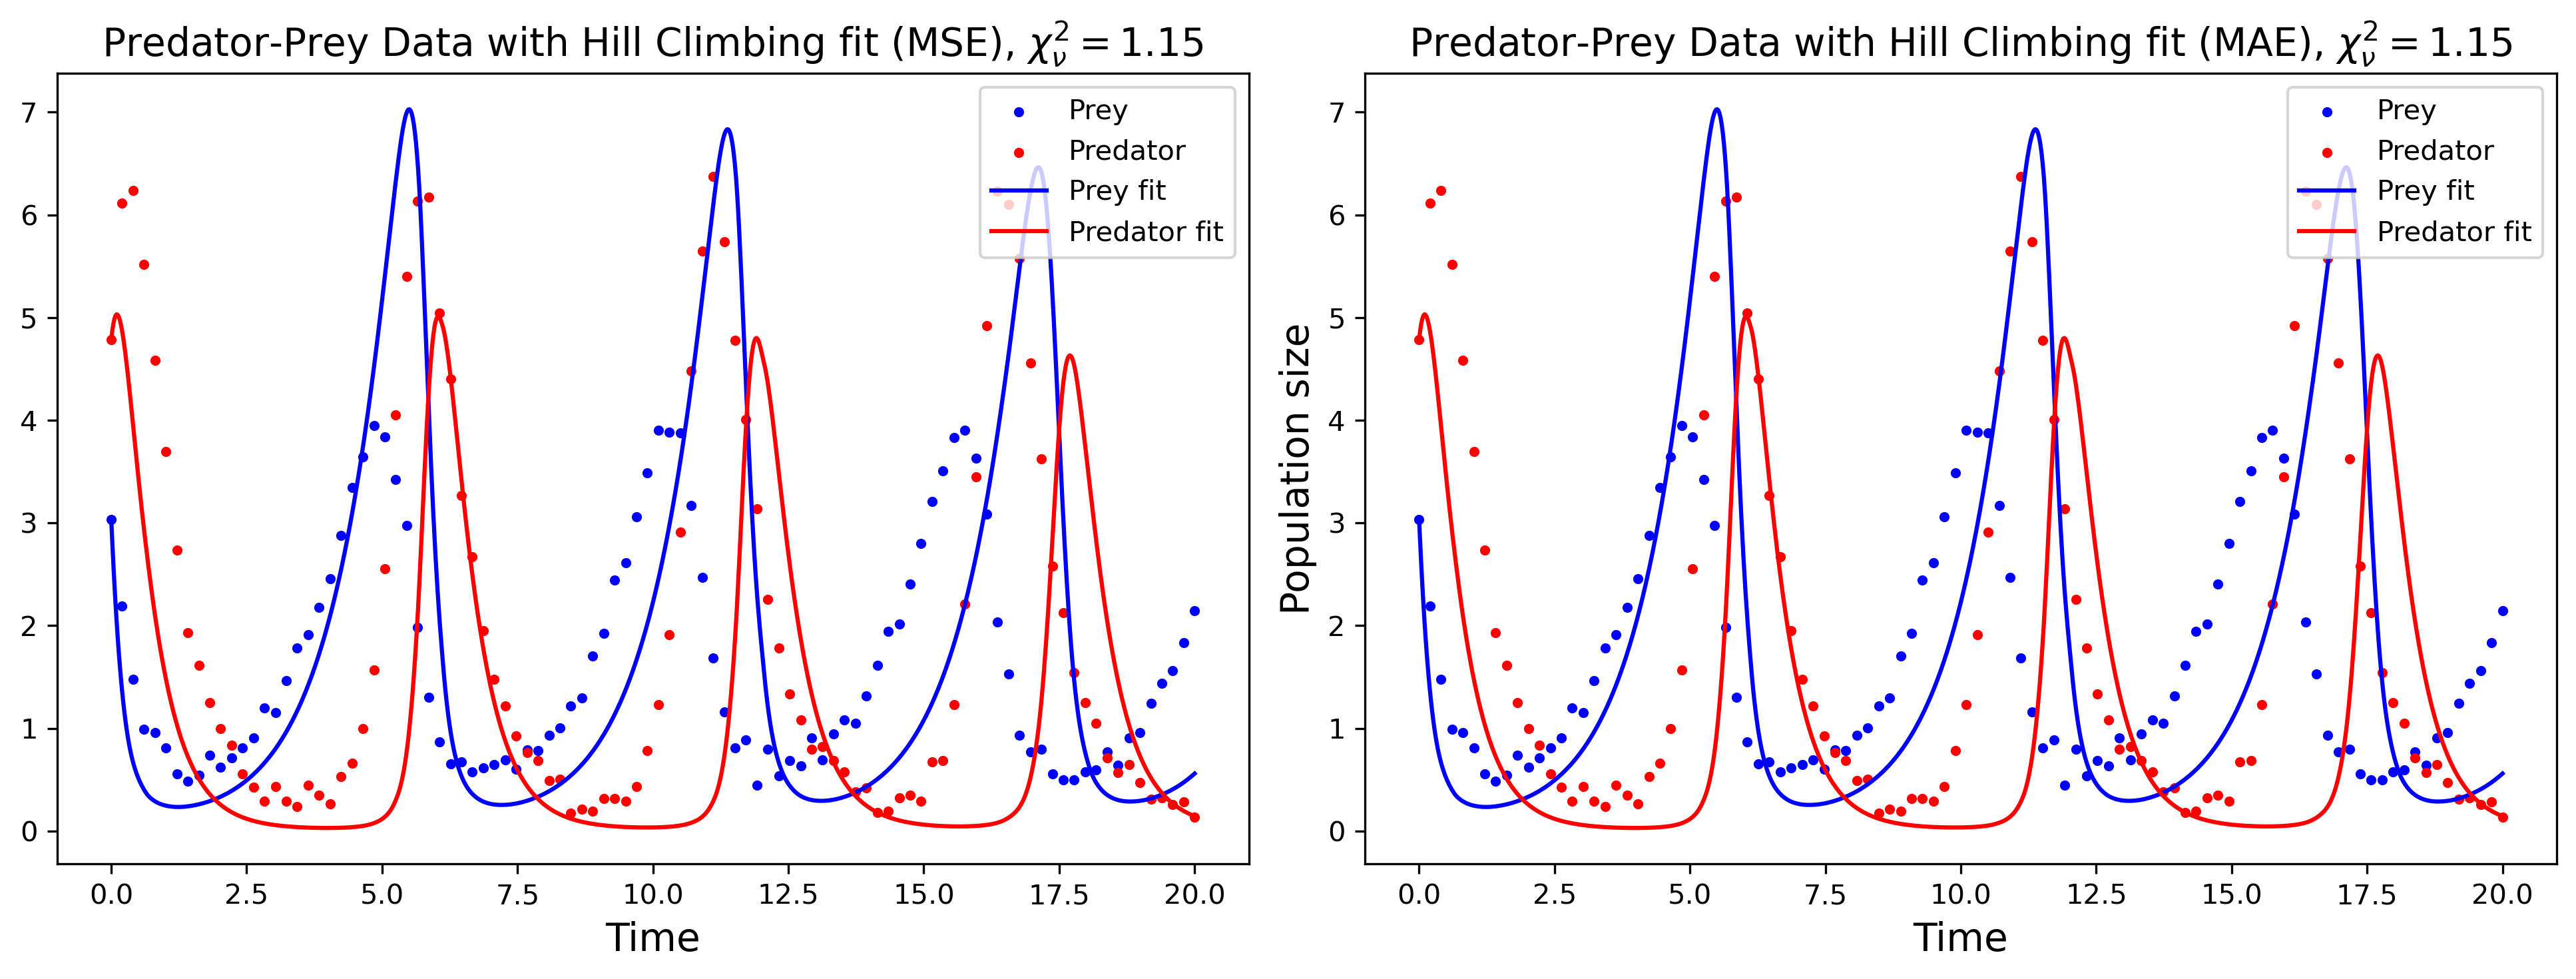

In [21]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.title(fr'Predator-Prey Data with Hill Climbing fit (MSE), $\chi^2_{{\nu}} = {{{round(chi2_MSE_hill, 2)}}}$', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.plot(t_MSE_fit, X_MSE_fit, color='blue', label='Prey fit')
plt.plot(t_MSE_fit, Y_MSE_fit, color='red', label='Predator fit')
plt.xlabel('Time', fontsize=14)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title(fr'Predator-Prey Data with Hill Climbing fit (MAE), $\chi^2_{{\nu}} = {{{round(chi2_MAE_hill, 2)}}}$', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.plot(t_MAE_fit, X_MAE_fit, color='blue', label='Prey fit')
plt.plot(t_MAE_fit, Y_MAE_fit, color='red', label='Predator fit')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [22]:
X_MAE_fit, Y_MAE_fit, t_MAE_fit = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], means_MAE)
X_MSE_fit, Y_MSE_fit, t_MSE_fit = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], means_MSE)

In [23]:
chi2_MSE_X_hill, chi2_MSE_Y_hill, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], means_MSE)
chi2_MAE_X_hill, chi2_MAE_Y_hill, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], means_MAE)
chi2_MSE_hill = reduced_chi2(chi2_MSE_X_hill, chi2_MSE_Y_hill)
chi2_MAE_hill = reduced_chi2(chi2_MAE_X_hill, chi2_MAE_Y_hill)
print(f'Reduced chi2 for Hill climbing using MSE: {chi2_MSE_hill}')
print(f'Reduced chi2 for Hill climbing using MAE: {chi2_MAE_hill}')

Reduced chi2 for Hill climbing using MSE: 2.059605879862664
Reduced chi2 for Hill climbing using MAE: 2.012817423539144


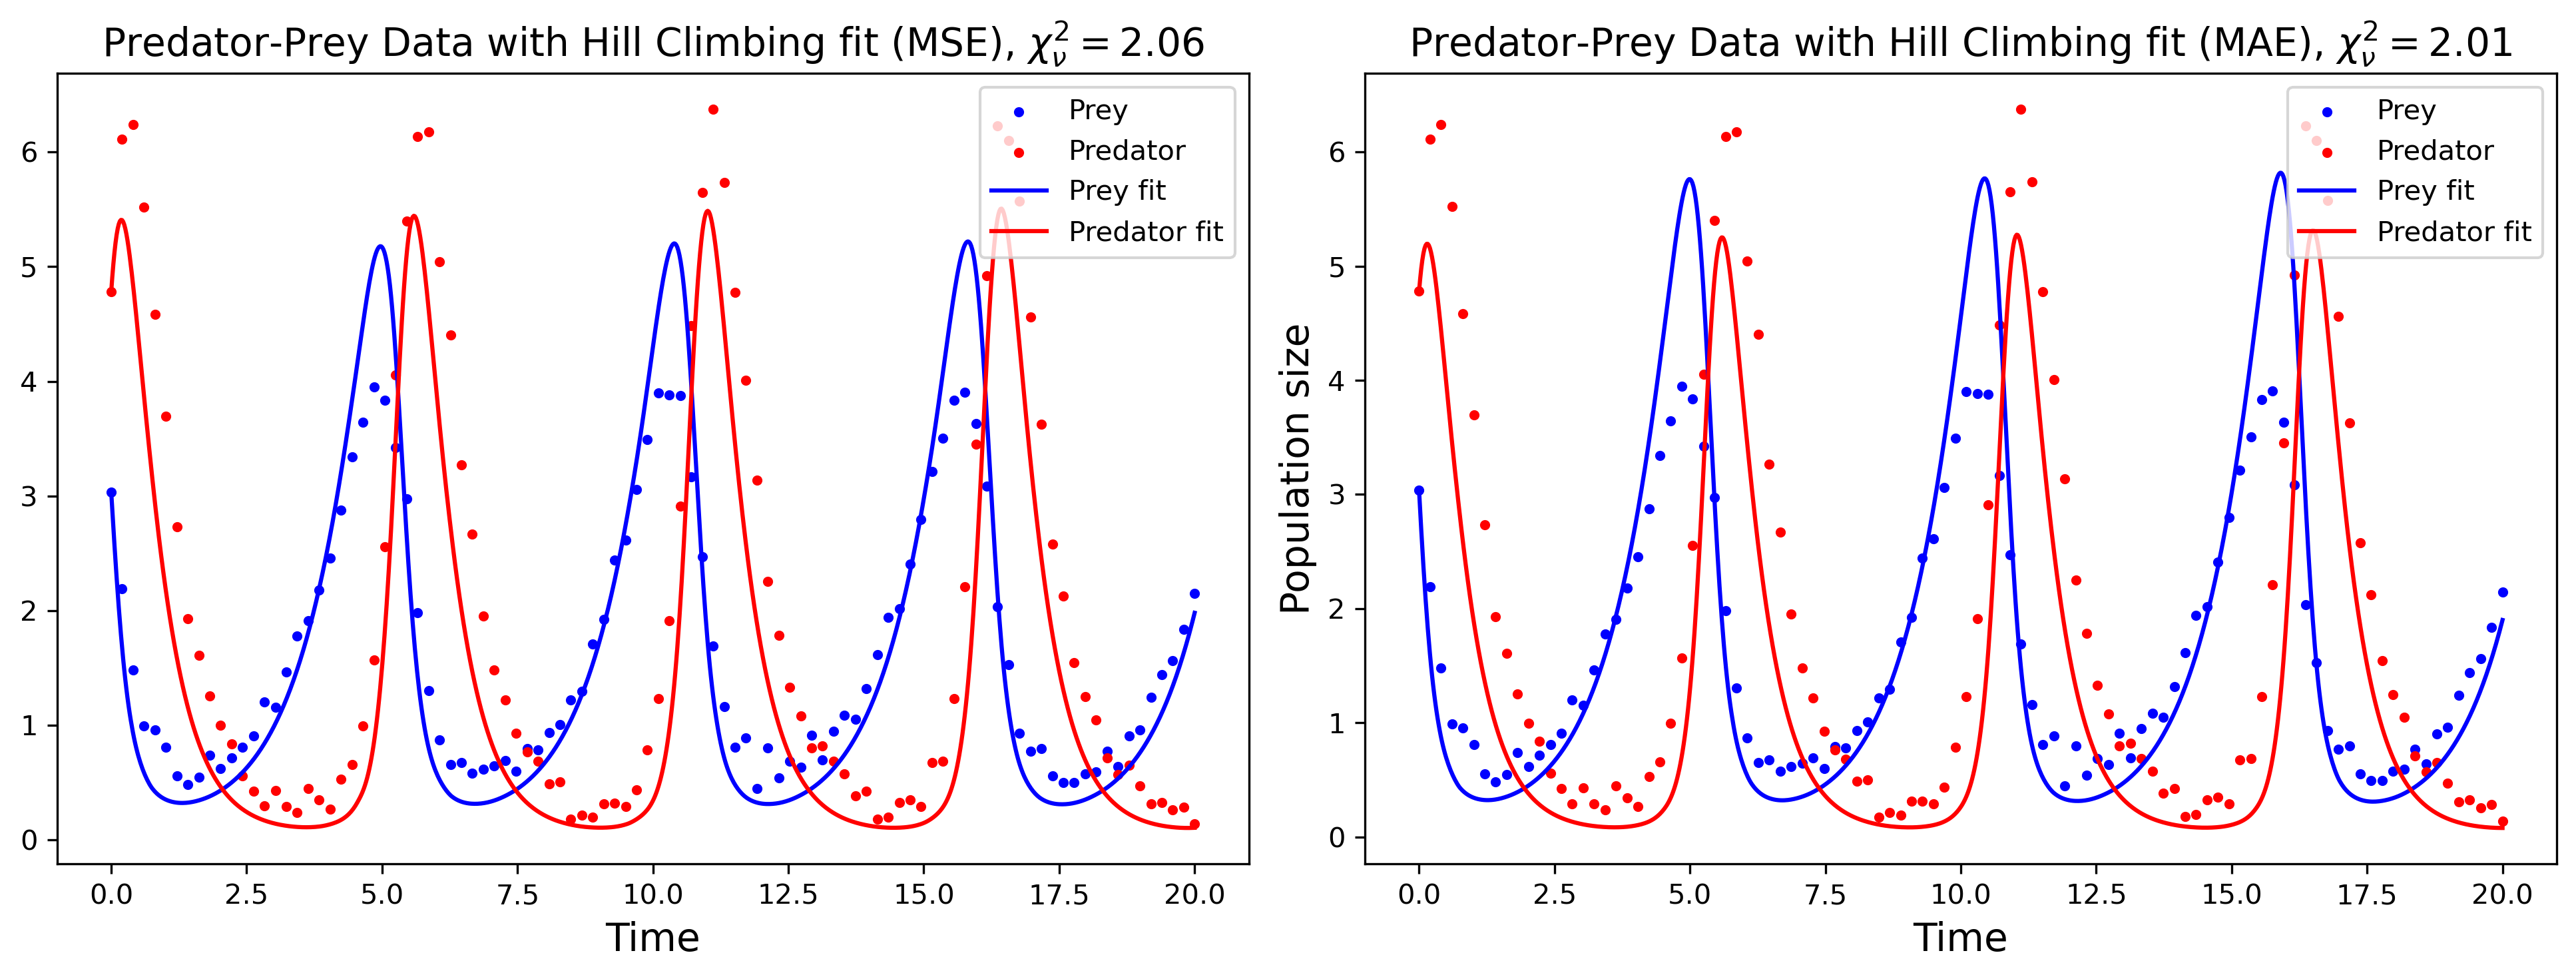

In [24]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.title(fr'Predator-Prey Data with Hill Climbing fit (MSE), $\chi^2_{{\nu}} = {{{round(chi2_MSE_hill, 2)}}}$', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.plot(t_MSE_fit, X_MSE_fit, color='blue', label='Prey fit')
plt.plot(t_MSE_fit, Y_MSE_fit, color='red', label='Predator fit')
plt.xlabel('Time', fontsize=14)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title(fr'Predator-Prey Data with Hill Climbing fit (MAE), $\chi^2_{{\nu}} = {{{round(chi2_MAE_hill, 2)}}}$', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.plot(t_MAE_fit, X_MAE_fit, color='blue', label='Prey fit')
plt.plot(t_MAE_fit, Y_MAE_fit, color='red', label='Predator fit')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

When updating al parameters simultanously and not each parameter individually. 

In [25]:
def hill_climbing_sim(init_guess, increment, iterations, obj_func, seed=1):
    a, b, c, d = init_guess
    lowest_error = 1e5
    err_list = []
    x_errs = []  # will be iterations + 1 long due to also having to compute the initial guess
    y_errs = []  # same as x_errs
    np.random.seed(seed)
    abcd_list = [a,b,c,d]
    abcd_incr_list = np.random.uniform(-increment, increment, (4, iterations))

    model_X, model_Y, model_t = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], [a, b, c, d])

    x_err = obj_func(X_data, model_X)
    y_err = obj_func(Y_data, model_Y)
    x_errs.append(x_err)
    y_errs.append(y_err)
    error_sum_old =  x_err + y_err


    for i in range(iterations):
        for j in range(len(abcd_list)):
            abcd_list[j] += abcd_incr_list[j, i]

        model_X, model_Y, model_t = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], abcd_list)
        error_sum_new = 1 *  obj_func(X_data, model_X) + 1 * obj_func(Y_data, model_Y)
        x_err = obj_func(X_data, model_X)
        y_err = obj_func(Y_data, model_Y)
        x_errs.append(x_err)
        y_errs.append(y_err)

        if error_sum_new < error_sum_old:
            error_sum_old = error_sum_new
        else:
            for j in range(len(abcd_list)):
                abcd_list[j] -= abcd_incr_list[j, i]
    return [abcd_list, x_errs, y_errs]

In [26]:
def simulation_wrapper_sim(init_guess, increment, iterations, obj_func, seed):
    return hill_climbing(init_guess, increment, iterations, obj_func, seed=seed)

def simulate_parallel_sim(n_runs, init_guess, increment, iterations, obj_func):
    results = Parallel(n_jobs=2)(delayed(simulation_wrapper_sim)(init_guess, increment, iterations, obj_func, seed=s) for s in range(n_runs))
    abcds = np.array([results[j][0] for j in range(n_runs)])

    errors_x = np.array([results[k][1] for k in range(n_runs)])
    errors_y = np.array([results[g][2] for g in range(n_runs)])
    return [abcds, errors_x, errors_y]

In [27]:
hill_clim_fit_MAE_sim = simulate_parallel_sim(50, [1, 1, 2, 1], 0.01, 1000, MAE)
hill_clim_fit_MSE_sim = simulate_parallel_sim(50, [1, 1, 2, 1], 0.01, 1000, MSE)

In [28]:
minimum_xerr = np.min(hill_clim_fit_MAE_sim[1][:,-1])
for i in range (len(hill_clim_fit_MAE_sim[1][:,-1])):
    if hill_clim_fit_MAE_sim[1][i,-1]== minimum_xerr:
        print(i)
        min_idx = i

42


In [29]:
means_MAE, conf_MAE = calc_mean_conf_hill(hill_clim_fit_MAE_sim[0])
for i in range(4):
    print(f'(MAE) Param: {means_MAE[i]} +- {conf_MAE[i]}')
means_MSE, conf_MSE = calc_mean_conf_hill(hill_clim_fit_MSE_sim[0])
for i in range(4):
    print(f'(MSE) Param: {means_MSE[i]} +- {conf_MSE[i]}')

(MAE) Param: 1.0387080641516986 +- 0.007695401006390349
(MAE) Param: 0.8285397777638043 +- 0.05016964186995589
(MAE) Param: 1.9544242136794563 +- 0.029218092317998517
(MAE) Param: 1.0339285979209556 +- 0.019153939778002643
(MSE) Param: 1.0441508891363327 +- 0.005705541086444049
(MSE) Param: 0.7663367195464801 +- 0.054170582600274
(MSE) Param: 1.9142524648183457 +- 0.031780635863244776
(MSE) Param: 1.0947306897471054 +- 0.029645622422425653


In [30]:
X_MAE_fit, Y_MAE_fit, t_MAE_fit = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], means_MAE)
X_MSE_fit, Y_MSE_fit, t_MSE_fit = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], means_MSE)

In [31]:
chi2_MSE_X_hill, chi2_MSE_Y_hill, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], means_MSE)
chi2_MAE_X_hill, chi2_MAE_Y_hill, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], means_MAE)
chi2_MSE_hill = reduced_chi2(chi2_MSE_X_hill, chi2_MSE_Y_hill)
chi2_MAE_hill = reduced_chi2(chi2_MAE_X_hill, chi2_MAE_Y_hill)
print(f'Reduced chi2 for Hill climbing using MSE: {chi2_MSE_hill}')
print(f'Reduced chi2 for Hill climbing using MAE: {chi2_MAE_hill}')

Reduced chi2 for Hill climbing using MSE: 2.059605879862664
Reduced chi2 for Hill climbing using MAE: 2.012817423539144


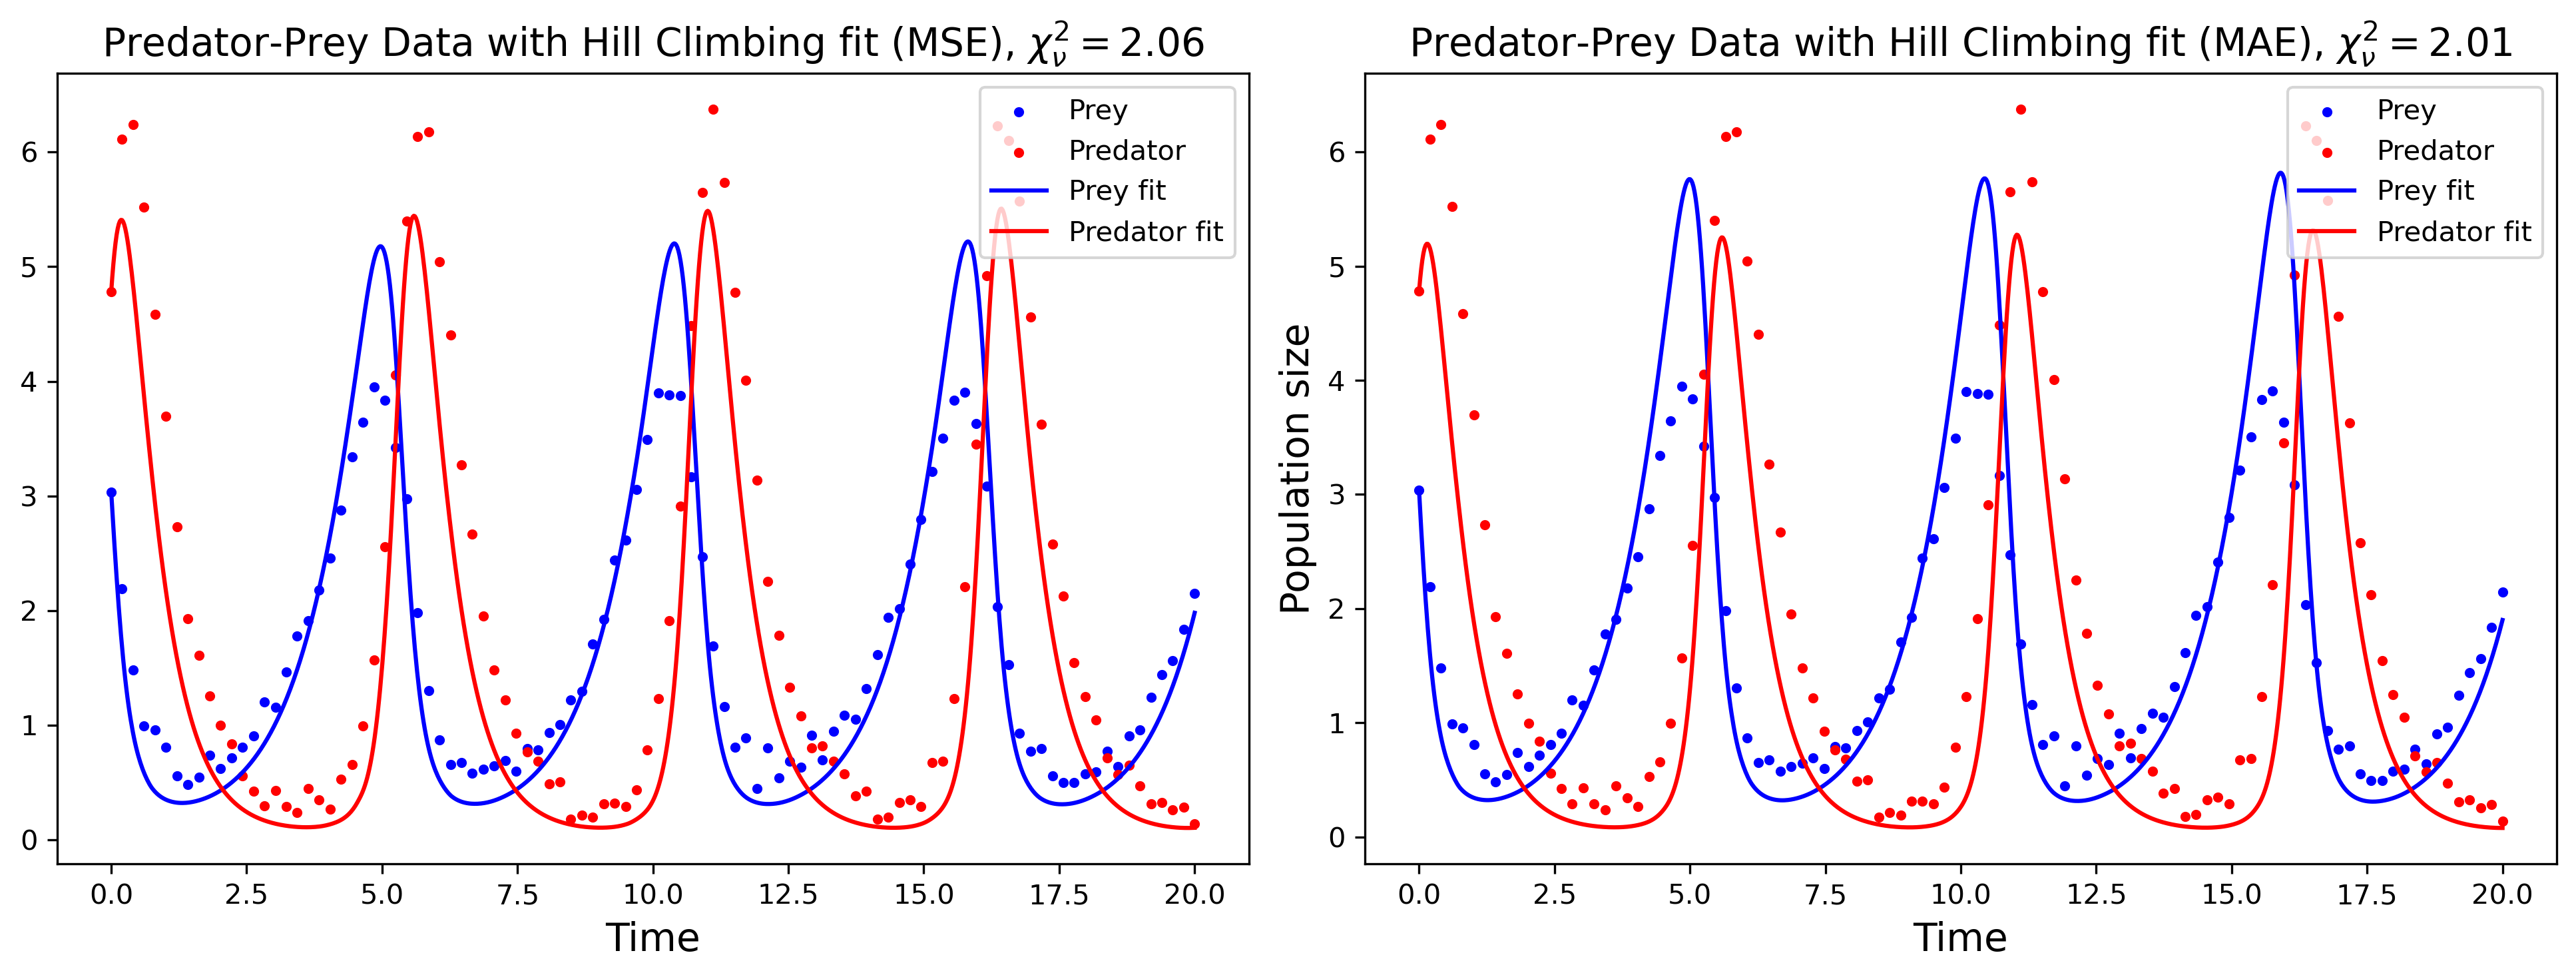

In [32]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.title(fr'Predator-Prey Data with Hill Climbing fit (MSE), $\chi^2_{{\nu}} = {{{round(chi2_MSE_hill, 2)}}}$', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.plot(t_MSE_fit, X_MSE_fit, color='blue', label='Prey fit')
plt.plot(t_MSE_fit, Y_MSE_fit, color='red', label='Predator fit')
plt.xlabel('Time', fontsize=14)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title(fr'Predator-Prey Data with Hill Climbing fit (MAE), $\chi^2_{{\nu}} = {{{round(chi2_MAE_hill, 2)}}}$', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.plot(t_MAE_fit, X_MAE_fit, color='blue', label='Prey fit')
plt.plot(t_MAE_fit, Y_MAE_fit, color='red', label='Predator fit')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Simulated Annealing

Below are again two different objective functions (MAE and MSE) to optimize the parameters using simulated annealing. We use `dual_annealing` from `scipy.optmize`. Since this library uses random sampling, we run multiple times and take the mean and confidence interval at the $p = 95\%$ confidence level.

In [27]:
def annealing_MAE(params):
    """Objective function for simulated annealing using the mean absolute error

    Args:
        params (list): list of model parameters

    Returns:
        float: total error for both fits
    """
    a, b, c, d = params
    model_X, model_Y, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], [a, b, c, d])
    error_X = np.mean(np.abs(X_data - model_X)) / X_data_var
    error_Y = np.mean(np.abs(Y_data - model_Y)) / Y_data_var
    return error_X + error_Y

def annealing_MSE(params, X_data, Y_data, t_data):
    """Objective function for simulated annealing using the mean squared error

    Args:
        params (list): list of model parameters

    Returns:
        float: total error for both fits
    """
    a, b, c, d = params
    model_X, model_Y, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], [a, b, c, d])
    error_X = np.mean((X_data - model_X) ** 2) / X_data_var
    error_Y = np.mean((Y_data - model_Y) ** 2) / Y_data_var
    return error_X + error_Y

bounds = [(0.4, 2.5), (0.4, 2.5), (0.4, 2.5), (0.4, 2.5)]

def run_annealing(obj_func, seed, *args):
    """Simulation wrapper for multithreading

    Args:
        obj_func (function): type of objective function, MAE or MSE
        seed (int): seed for reproducability

    Returns:
        array: array of optimal parameters
    """
    result = dual_annealing(obj_func, bounds, seed=seed, args=args)
    return result.x

In [ ]:
annealing_MSE_results = Parallel(n_jobs=-1)(delayed(run_annealing)(annealing_MSE, seed, X_data, Y_data, t_data) for seed in range(100))
annealing_MAE_results = Parallel(n_jobs=-1)(delayed(run_annealing)(annealing_MAE, seed) for seed in range(100))

In [ ]:
annealing_MSE_results = np.array(annealing_MSE_results)
annealing_MAE_results = np.array(annealing_MAE_results)

means_MSE_SA, conf_MSE_SA = calc_mean_conf(annealing_MSE_results)
means_MAE_SA, conf_MAE_SA = calc_mean_conf(annealing_MAE_results)

In [31]:
for i in range(4):
    print(f'(MSE) Param: {means_MSE_SA[i]} +- {conf_MSE_SA[i]}')
    print(f'(MAE) Param: {means_MAE_SA[i]} +- {conf_MAE_SA[i]}')

(MSE) Param: 0.7785487976442155 +- 0.06400911360209724
(MSE) Param: 0.4158909139128235 +- 0.020942621406860616
(MSE) Param: 2.279160199756073 +- 0.2293712382556416
(MSE) Param: 1.3161303537913827 +- 0.1260407019283407


In [43]:
anneal_fit_MSE_X, anneal_fit_MSE_Y, anneal_fit_t = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], means_MSE_SA)
anneal_fit_MAE_X, anneal_fit_MAE_Y, anneal_fit_t = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], means_MAE_SA)

In [44]:
chi2_MSE_X_SA, chi2_MSE_Y_SA, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], means_MSE_SA)
chi2_MAE_X_SA, chi2_MAE_Y_SA, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], means_MAE_SA)
chi2_MSE_SA = reduced_chi2(chi2_MSE_X_SA, chi2_MSE_Y_SA)
chi2_MAE_SA = reduced_chi2(chi2_MAE_X_SA, chi2_MAE_Y_SA)
print(f'Reduced chi2 using MSE: {chi2_MSE_SA}')
print(f'Reduced chi2 using MAE: {chi2_MAE_SA}')

Reduced chi2 using MSE: 1.0215039884240502
Reduced chi2 using SSE: 1.0225333477380476


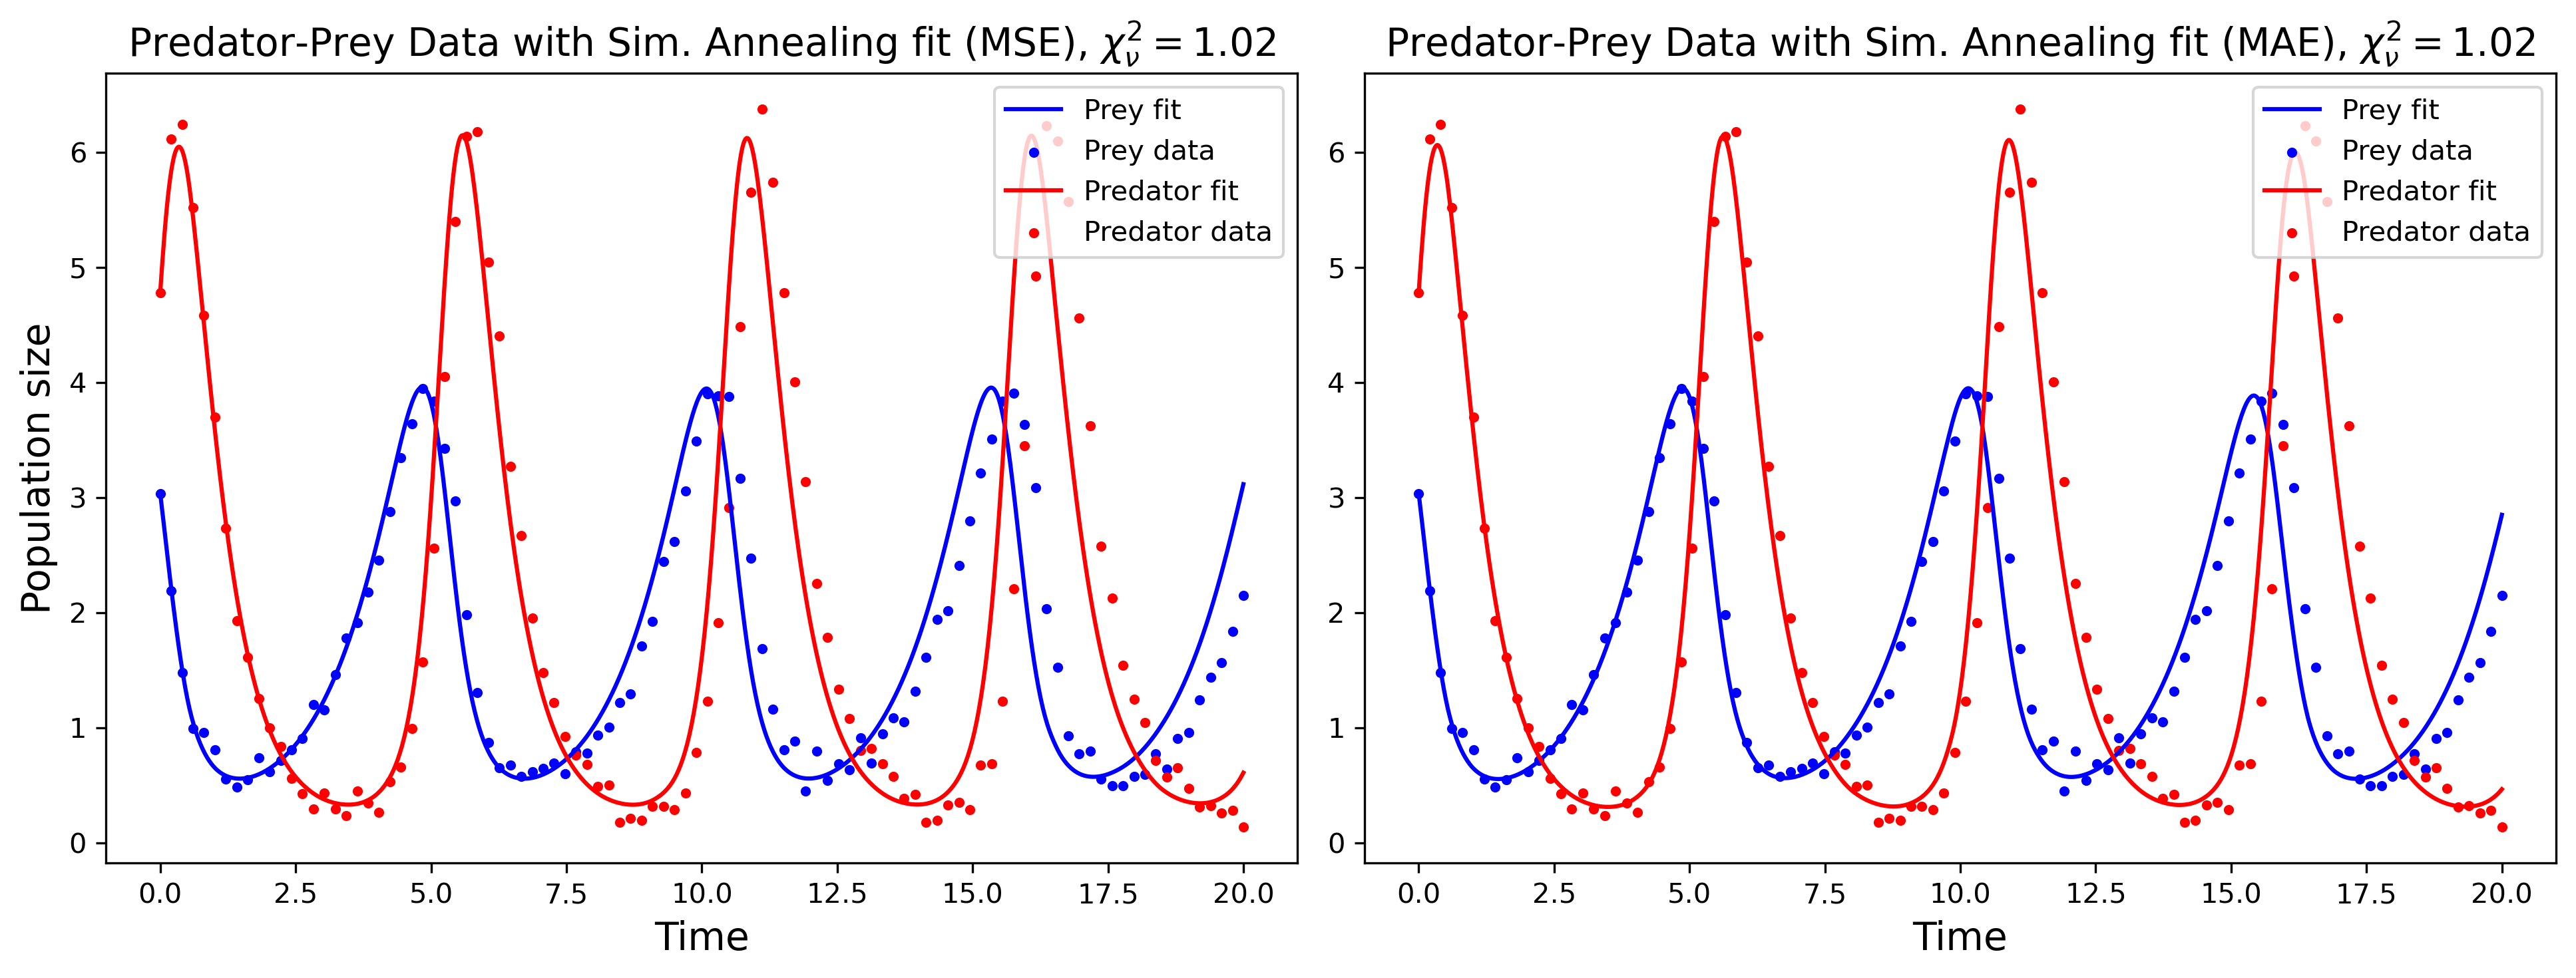

In [45]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.title(fr'Predator-Prey Data with Sim. Annealing fit (MSE), $\chi^2_{{\nu}} = {{{round(chi2_MSE_SA, 2)}}}$', fontsize=14)
plt.plot(anneal_fit_t, anneal_fit_MSE_X, color='blue', label='Prey fit')
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey data')
plt.plot(anneal_fit_t, anneal_fit_MSE_Y, color='red', label='Predator fit')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator data')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title(fr'Predator-Prey Data with Sim. Annealing fit (MAE), $\chi^2_{{\nu}} = {{{round(chi2_MAE_SA, 2)}}}$', fontsize=14)
plt.plot(anneal_fit_t, anneal_fit_MAE_X, color='blue', label='Prey fit')
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey data')
plt.plot(anneal_fit_t, anneal_fit_MAE_Y, color='red', label='Predator fit')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator data')
plt.xlabel('Time', fontsize=14)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

We determine how many data points we can delete while still getting a good fit. First, we fix the $x$ data and randomly delete points from the $y$ data, we then calculate the parameters with less data and if the resulting parameters fall within the confidence interval of the original parameters, we conclude that we can still reverse engineer the dynamics. For this part we use simulated annealing with the MSE as objective function, since that gave the best fit. 

In [9]:
annealing_MSE_baseline = Parallel(n_jobs=-1)(delayed(run_annealing)(annealing_MSE, seed) for seed in range(100))

In [10]:
annealing_MSE_baseline = np.array(annealing_MSE_baseline)
mean_baseline, conf_baseline = calc_mean_conf(annealing_MSE_baseline)

for i in range(4):
    print(f'Param: {mean_baseline[i]} +- {conf_baseline[i]}')

Param: 0.9242856901711229 +- 0.040696823521751455
Param: 0.46359348384349275 +- 0.014098576210999362
Param: 1.9416705232197995 +- 0.06832586218032626
Param: 1.1184404225276419 +- 0.03882623083516356


In [10]:
def annealing_deletion_Y(params, X_data_copy, Y_data_copy, t_data_copy):
    """Objective function for simulated annealing with data point deletion in the predator population

    Args:
        params (list): list of model parameters
        X_data_copy (array): predator populations from data
        Y_data_copy (array): prey populations from data
        t_data_copy (array): time array from data

    Returns:
        float: total error of both populations
    """
    a, b, c, d = params
    X_model, _, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], [a, b, c, d])
    _, Y_model, _ = solve_LV(0, 20, t_data_copy, [X_data[0], Y_data[0]], [a, b, c, d])
    error_X = np.mean((X_data_copy - X_model) ** 2)
    error_Y = np.mean((Y_data_copy - Y_model) ** 2)
    return error_X + error_Y

def annealing_deletion_X(params, X_data_copy, Y_data_copy, t_data_copy):
    """Objective function for simulated annealing with data point deletion in the prey population

    Args:
        params (list): list of model parameters
        X_data_copy (array): predator populations from data
        Y_data_copy (array): prey populations from data
        t_data_copy (array): time array from data

    Returns:
        float: total error of both populations
    """
    a, b, c, d = params
    X_model, _, _ = solve_LV(0, 20, t_data_copy, [X_data[0], Y_data[0]], [a, b, c, d])
    _, Y_model, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], [a, b, c, d])
    error_X = np.mean((X_data_copy - X_model) ** 2)
    error_Y = np.mean((Y_data_copy - Y_model) ** 2)
    return error_X + error_Y

In [11]:
def optimization_with_deletion(num_deletions, deletion_func):
    """Calculates optimal parameters for some number of deletions in the predator or prey population

    Args:
        num_deletions (list): list of number of deletions
        deletion_func (function): given the function, points are deleted in the predator of prey population

    Returns:
        arrays: arrays for the mean of the parameters and the corresponding confidence intervals
    """
    X_data_copy = X_data.copy()
    Y_data_copy = Y_data.copy()
    t_data_copy = t_data.copy()
    mean_params = np.zeros((len(num_deletions), 4))
    conf_params = np.zeros((len(num_deletions), 4))

    for i, deletions in enumerate(num_deletions):
        # Delete random data points
        np.random.seed(i)
        deletion_idx = np.random.choice(range(1, len(Y_data_copy)), size=deletions, replace=False)
        t_data_copy = np.delete(t_data_copy, deletion_idx)

        if deletion_func == annealing_deletion_Y:
            Y_data_copy = np.delete(Y_data_copy, deletion_idx)

            deletion_Y_params = Parallel(n_jobs=-1)(delayed(run_annealing)(deletion_func, seed*seed, X_data_copy, Y_data_copy, t_data_copy) for seed in range(25))
            deletion_Y_params = np.array(deletion_Y_params)
            means, confs = calc_mean_conf(deletion_Y_params)

            Y_data_copy = Y_data.copy()

        else:
            X_data_copy = np.delete(X_data_copy, deletion_idx)

            deletion_X_params = Parallel(n_jobs=-1)(delayed(run_annealing)(deletion_func, seed*seed, X_data_copy, Y_data_copy, t_data_copy) for seed in range(25))
            deletion_X_params = np.array(deletion_X_params)
            means, confs = calc_mean_conf(deletion_X_params)

            X_data_copy = X_data.copy()

        mean_params[i, :] = means
        conf_params[i, :] = confs

        t_data_copy = t_data.copy()

    return mean_params, conf_params

In [34]:
num_deletions = [20, 40, 60, 80, 85, 88, 90, 95]
mean_params_Y_del, conf_params_Y_del = optimization_with_deletion(num_deletions, annealing_deletion_Y)

In [37]:
mean_params_X_del, conf_params_X_del = optimization_with_deletion(num_deletions, annealing_deletion_X)

Plotting the deletions in the predator populations vs. the baseline with all data:

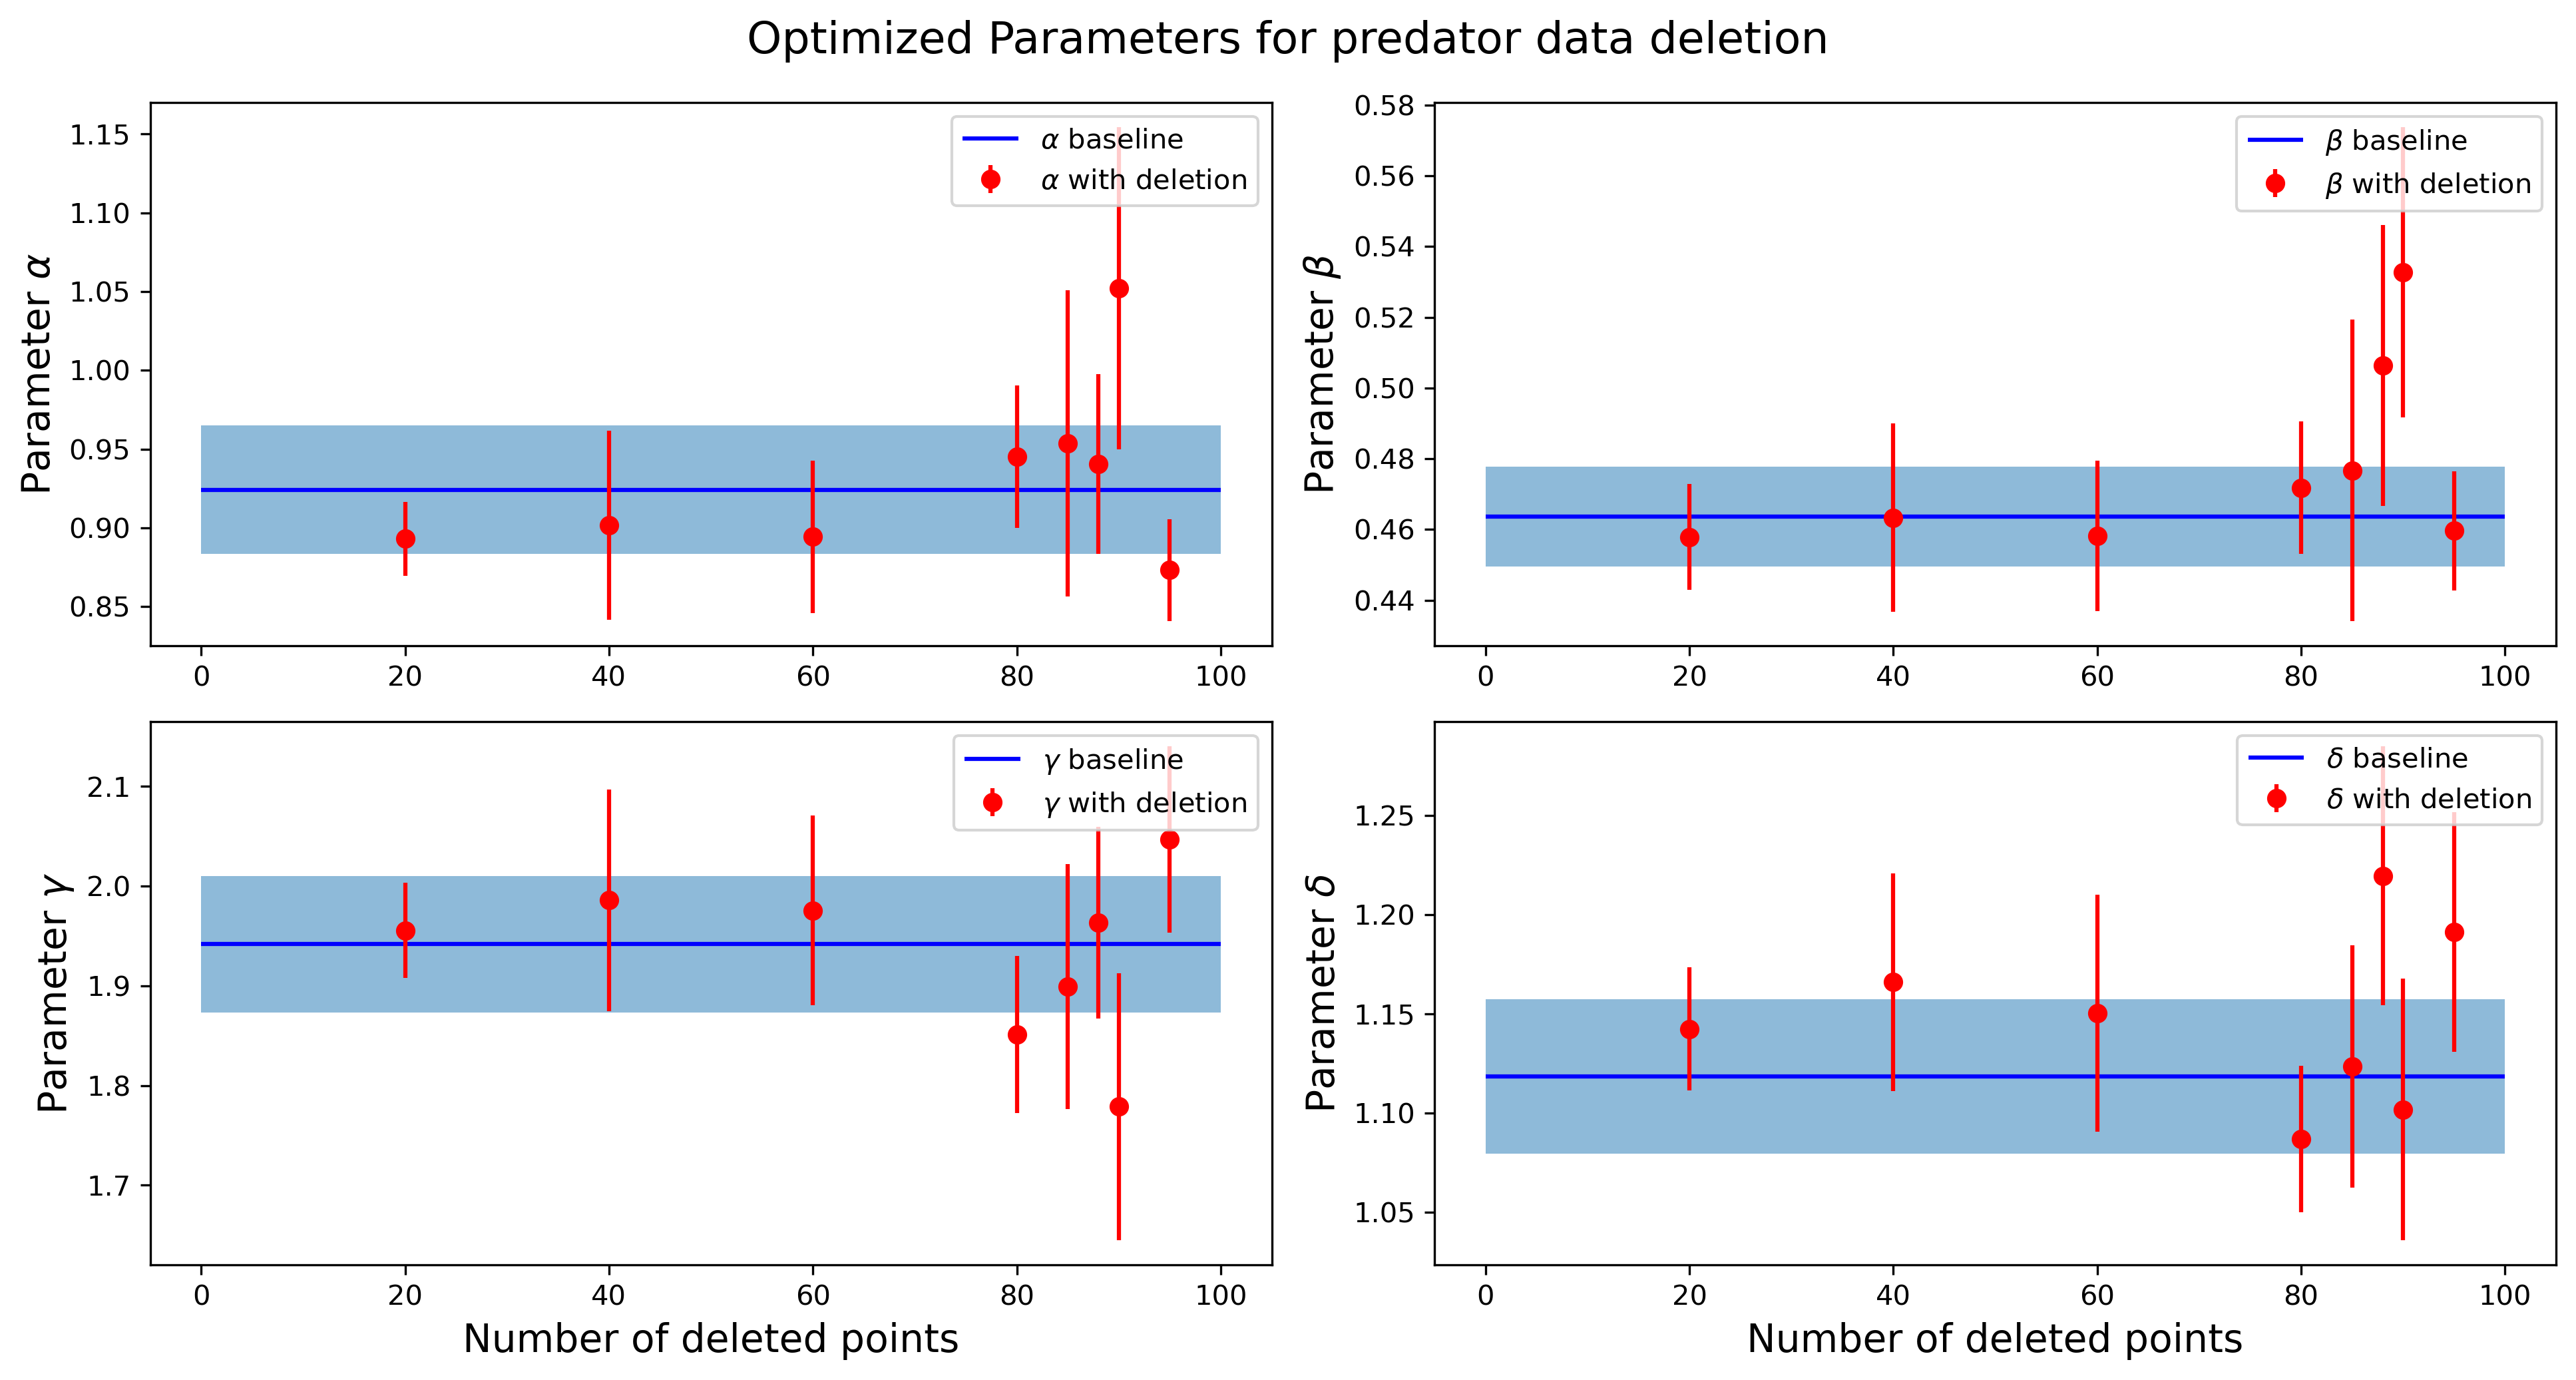

In [36]:
x_range = range(0, 101)

plt.figure(figsize=(13, 7))
plt.suptitle('Optimized Parameters for predator data deletion', fontsize=16)

plt.subplot(2, 2, 1)
plt.hlines(mean_baseline[0], xmin=0, xmax=100, color='blue', label=r'$\alpha$ baseline')
plt.fill_between(x_range, mean_baseline[0] - conf_baseline[0], mean_baseline[0] + conf_baseline[0], alpha=0.5)
plt.errorbar(num_deletions, mean_params_Y_del[:, 0], yerr=conf_params_Y_del[:, 0], fmt='o', color='red', label=r'$\alpha$ with deletion')
plt.ylabel(r'Parameter $\alpha$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 2)
plt.hlines(mean_baseline[1], xmin=0, xmax=100, color='blue', label=r'$\beta$ baseline')
plt.fill_between(x_range, mean_baseline[1] - conf_baseline[1], mean_baseline[1] + conf_baseline[1], alpha=0.5)
plt.errorbar(num_deletions, mean_params_Y_del[:, 1], yerr=conf_params_Y_del[:, 1], fmt='o', color='red', label=r'$\beta$ with deletion')
plt.ylabel(r'Parameter $\beta$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 3)
plt.hlines(mean_baseline[2], xmin=0, xmax=100, color='blue', label=r'$\gamma$ baseline')
plt.fill_between(x_range, mean_baseline[2] - conf_baseline[2], mean_baseline[2] + conf_baseline[2], alpha=0.5)
plt.errorbar(num_deletions, mean_params_Y_del[:, 2], yerr=conf_params_Y_del[:, 2], fmt='o', color='red', label=r'$\gamma$ with deletion')
plt.xlabel('Number of deleted points', fontsize=14)
plt.ylabel(r'Parameter $\gamma$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 4)
plt.hlines(mean_baseline[3], xmin=0, xmax=100, color='blue', label=r'$\delta$ baseline')
plt.fill_between(x_range, mean_baseline[3] - conf_baseline[3], mean_baseline[3] + conf_baseline[3], alpha=0.5)
plt.errorbar(num_deletions, mean_params_Y_del[:, 3], yerr=conf_params_Y_del[:, 3], fmt='o', color='red', label=r'$\delta$ with deletion')
plt.xlabel('Number of deleted points', fontsize=14)
plt.ylabel(r'Parameter $\delta$', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

Plotting the deletions in the prey populations vs. the baseline with all data:

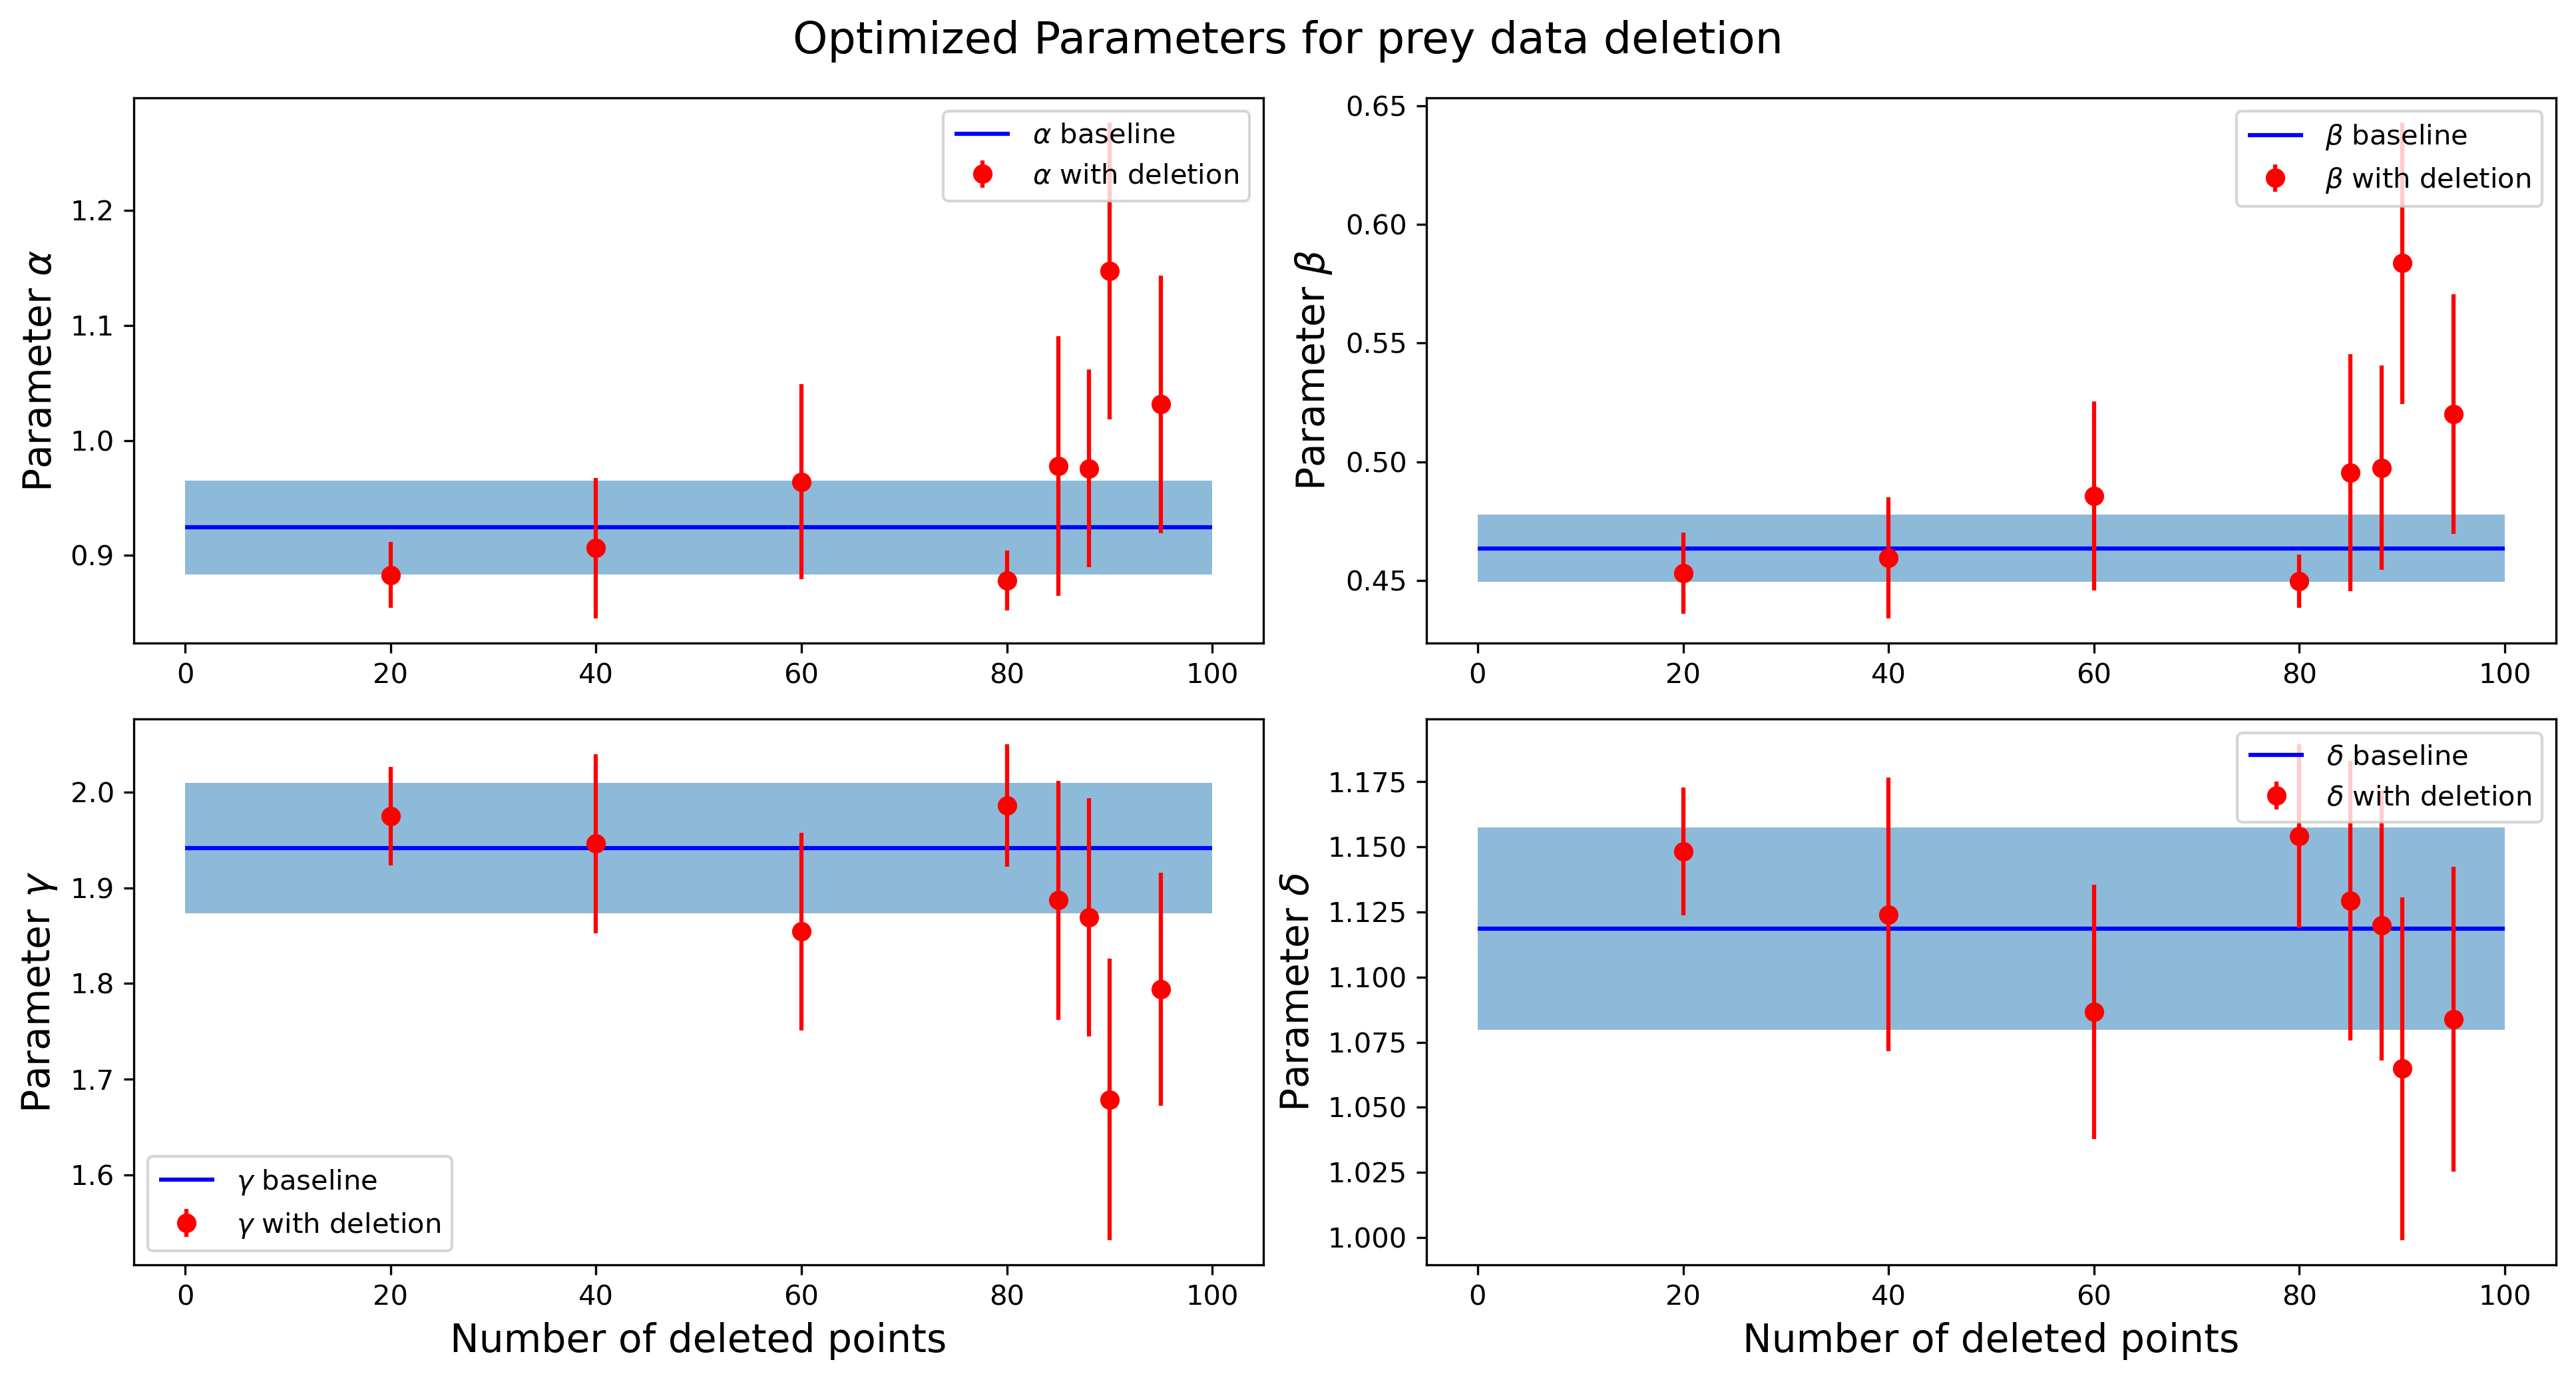

In [38]:
plt.figure(figsize=(13, 7))
plt.suptitle('Optimized Parameters for prey data deletion', fontsize=16)

plt.subplot(2, 2, 1)
plt.hlines(mean_baseline[0], xmin=0, xmax=100, color='blue', label=r'$\alpha$ baseline')
plt.fill_between(x_range, mean_baseline[0] - conf_baseline[0], mean_baseline[0] + conf_baseline[0], alpha=0.5)
plt.errorbar(num_deletions, mean_params_X_del[:, 0], yerr=conf_params_X_del[:, 0], fmt='o', color='red', label=r'$\alpha$ with deletion')
plt.ylabel(r'Parameter $\alpha$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 2)
plt.hlines(mean_baseline[1], xmin=0, xmax=100, color='blue', label=r'$\beta$ baseline')
plt.fill_between(x_range, mean_baseline[1] - conf_baseline[1], mean_baseline[1] + conf_baseline[1], alpha=0.5)
plt.errorbar(num_deletions, mean_params_X_del[:, 1], yerr=conf_params_X_del[:, 1], fmt='o', color='red', label=r'$\beta$ with deletion')
plt.ylabel(r'Parameter $\beta$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 3)
plt.hlines(mean_baseline[2], xmin=0, xmax=100, color='blue', label=r'$\gamma$ baseline')
plt.fill_between(x_range, mean_baseline[2] - conf_baseline[2], mean_baseline[2] + conf_baseline[2], alpha=0.5)
plt.errorbar(num_deletions, mean_params_X_del[:, 2], yerr=conf_params_X_del[:, 2], fmt='o', color='red', label=r'$\gamma$ with deletion')
plt.xlabel('Number of deleted points', fontsize=14)
plt.ylabel(r'Parameter $\gamma$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 4)
plt.hlines(mean_baseline[3], xmin=0, xmax=100, color='blue', label=r'$\delta$ baseline')
plt.fill_between(x_range, mean_baseline[3] - conf_baseline[3], mean_baseline[3] + conf_baseline[3], alpha=0.5)
plt.errorbar(num_deletions, mean_params_X_del[:, 3], yerr=conf_params_X_del[:, 3], fmt='o', color='red', label=r'$\delta$ with deletion')
plt.xlabel('Number of deleted points', fontsize=14)
plt.ylabel(r'Parameter $\delta$', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

Now, we know that we can delete roughly 80-85 points from each dataset, we combine the reduced time-series and again estimate the optimal parameters. If these parameters values are within the confidence interval of the baseline, we succesfully reverse-engineered the system with less data points.

In [ ]:
def annealing_reduced_time_series(params, X_data_copy, Y_data_copy, t_data_copy):
    """Objective function for simulated annealing with using reduced time series for the populations
    Args:
        params (list): list of model parameters
        X_data_copy (array): predator populations from data
        Y_data_copy (array): prey populations from data
        t_data_copy (array): time array from data

    Returns:
        float: total error of both populations
    """
    a, b, c, d = params
    X_model, _, _ = solve_LV(0, 20, t_data_copy, [X_data[0], Y_data[0]], [a, b, c, d])
    _, Y_model, _ = solve_LV(0, 20, t_data_copy, [X_data[0], Y_data[0]], [a, b, c, d])
    error_X = np.mean((X_data_copy - X_model) ** 2)
    error_Y = np.mean((Y_data_copy - Y_model) ** 2)
    return error_X + error_Y

In [58]:
num_del = 85
num_rand_arrays = 1

np.random.seed(69)
deletion_indeces = [np.random.choice(range(1, 100), size=num_del, replace=False) for i in range(num_rand_arrays)]

In [59]:
X_data_copy = X_data.copy()
Y_data_copy = Y_data.copy()
t_data_copy = t_data.copy()

mean_arr = np.zeros((num_rand_arrays, 4))
conf_arr = np.zeros((num_rand_arrays, 4))
chi_squareds = np.zeros(num_rand_arrays)

for i, rand_array in enumerate(deletion_indeces):
    t_data_copy = np.delete(t_data_copy, rand_array)
    X_data_copy = np.delete(X_data_copy, rand_array)
    Y_data_copy = np.delete(Y_data_copy, rand_array)

    deletion_params = Parallel(n_jobs=-1)(delayed(run_annealing)(annealing_MSE, seed*seed, X_data_copy, Y_data_copy, t_data_copy) for seed in range(25))
    deletion_params = np.array(deletion_params)
    means, confs = calc_mean_conf(deletion_params)

    X_fit, Y_fit, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], means)
    chi2 = reduced_chi2(X_fit, Y_fit)

    mean_arr[i, :] = means
    conf_arr[i, :] = confs
    chi_squareds[i] = chi2

    # X_data_copy = X_data.copy()
    # Y_data_copy = Y_data.copy()
    # t_data_copy = t_data.copy()


In [60]:
print(f'{mean_arr}\n{conf_arr}\n{chi_squareds}')

[[0.8938461  0.46589701 1.97533393 1.13901867]]
[[0.04003021 0.02042616 0.09106923 0.04333824]]
[1.09185804]


In [61]:
red_time_X_fit, red_time_Y_fit, red_time_t_fit = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], mean_arr[0])

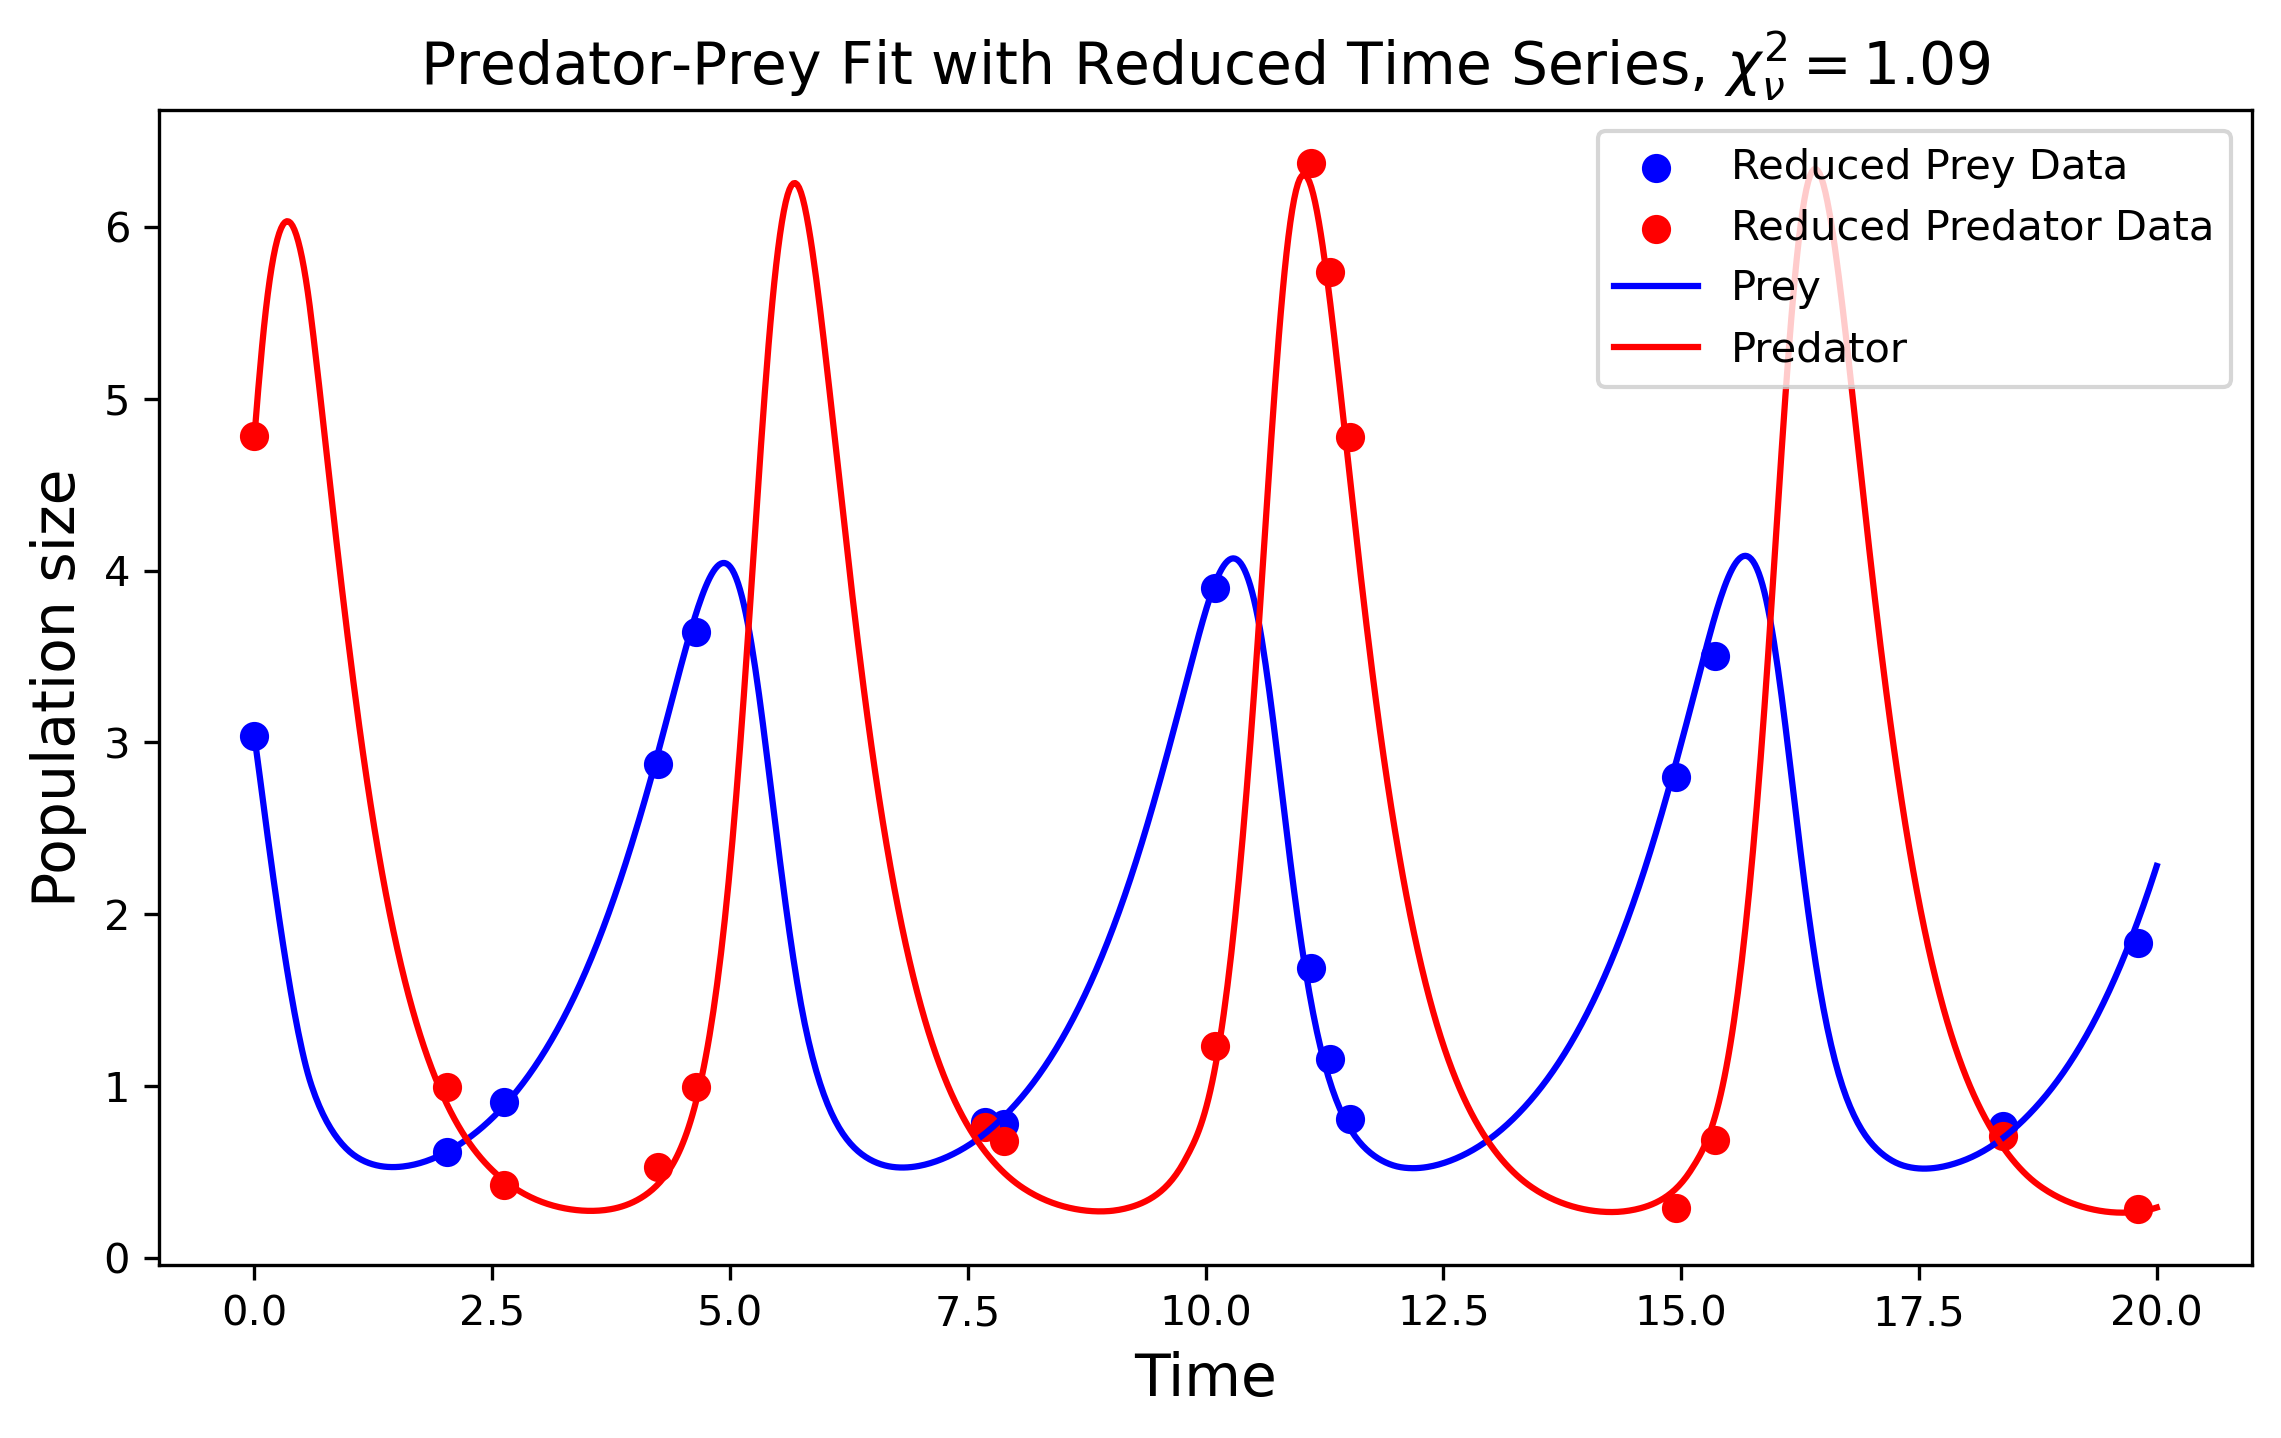

In [64]:
plt.figure(figsize=(9,5))
plt.title(fr'Predator-Prey Fit with Reduced Time Series, $\chi^2_\nu = {{{round(chi_squareds[0],2)}}}$', fontsize=14)
plt.scatter(t_data_copy, X_data_copy, color='blue', label='Reduced Prey Data')
plt.scatter(t_data_copy, Y_data_copy, color='red', label='Reduced Predator Data')
plt.plot(red_time_t_fit, red_time_X_fit, color='blue', label='Prey')
plt.plot(red_time_t_fit, red_time_Y_fit, color='red', label='Predator')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend(loc='upper right')
plt.show()